# Install Dependency

In [2]:
# pip install scikit-learn

In [3]:
# pip install matplotlib

In [4]:
# pip install tensorboard

In [5]:
# pip install tqdm

In [6]:
# pip install transformers

In [7]:
# pip install torchcam


In [8]:
# pip install shap

In [9]:
# pip install lime scikit-image

In [10]:
# pip install grad-cam

In [11]:
# pip install captum

# Dataset preaparing

In [12]:
import os
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch
import torch.nn as nn
from torchvision import models

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to dataset folders
diabetic_folder = r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Data\Diabetic"
normal_folder = r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Data\Normal"

# Transformations for training data (with augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Transformations for validation and test data (without augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Combine both folders into a single dataset
dataset = datasets.ImageFolder(
    root=r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Data"
)

# Explicitly verify class names and indices
print(f"Class to index mapping: {dataset.class_to_idx}")

# Splitting indices for train, validation, and test sets
train_idx, temp_idx = train_test_split(
    list(range(len(dataset))),
    test_size=0.3,  # 30% for validation and test
    stratify=dataset.targets,  # Maintain class balance
    random_state=42
)
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,  # Split remaining 30% equally into validation and test
    stratify=[dataset.targets[i] for i in temp_idx],  # Maintain class balance
    random_state=42
)

# Create subsets for DataLoader
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

# Apply transformations to subsets
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Verify dataset sizes
print(f"Total images: {len(dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Test images: {len(test_dataset)}")


Using device: cuda
Class to index mapping: {'Diabetic': 0, 'Normal': 1}
Total images: 11156
Training images: 7809
Validation images: 1673
Test images: 1674


# Parameter Setup

In [13]:
GLOBAL_EPOCH = 50          # or whatever value you want
GLOBAL_Lr = 5e-4           # or any learning rate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
eva_type = "full"          # (example) naming the evaluation file

# Training Function

In [14]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter  # For logging
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.cuda.amp as amp  # For mixed precision training

def train_model(model, train_loader, val_loader, num_epochs, lr=0.001, wd=1e-4,
                log_dir="./logs", save_path="best_model.pth", patience=5,
                use_scheduler=True, use_mixed_precision=False):
    model = model.to(device)

    criterion = nn.BCEWithLogitsLoss()  # For binary classification
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    scheduler = None
    if use_scheduler:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    writer = SummaryWriter(log_dir=log_dir)

    best_val_loss = float("inf")
    epochs_without_improvement = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    scaler = amp.GradScaler() if use_mixed_precision else None

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        # Training
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.float().to(device).unsqueeze(1)
            optimizer.zero_grad()

            with amp.autocast(enabled=use_mixed_precision):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            if use_mixed_precision:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) > 0.6).float()
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Accuracy/Train", train_accuracy, epoch)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs, labels = inputs.to(device), labels.float().to(device).unsqueeze(1)
                outputs = model(inputs)

                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                preds = (torch.sigmoid(outputs) > 0.6).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        writer.add_scalar("Loss/Validation", val_loss, epoch)
        writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)

        # Save best model weights
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print("Validation loss improved. Model weights saved!")
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            print(f"No improvement in validation loss for {epochs_without_improvement} epoch(s).")

        print(f"Epoch {epoch + 1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        if use_scheduler:
            scheduler.step(val_loss)

        if epochs_without_improvement >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs! Best Val Loss: {best_val_loss:.4f}")
            break

    print("Training Complete!")

    # Plotting
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Evaluation Function

In [15]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd  # <-- For saving CSV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm.auto import tqdm  # <-- Smoother tqdm for all environments (optional but better)

def evaluate_model(model, test_loader, criterion, model_name,
                   checkpoint_path=None, output_file="evaluation_results.txt",
                   save_dir="./results"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # If checkpoint is provided, load it
    if checkpoint_path is not None and os.path.exists(checkpoint_path):
        print(f"Loading best model from {checkpoint_path}...")
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    
    model = model.to(device)
    model.eval()

    os.makedirs(save_dir, exist_ok=True)

    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"Evaluating {model_name}"):
            inputs, labels = inputs.to(device), labels.float().to(device)

            if labels.ndim == 1:
                labels = labels.unsqueeze(1)

            outputs = model(inputs)

            # Handle output if model outputs a dict (like ViT sometimes)
            if isinstance(outputs, dict) and "logits" in outputs:
                outputs = outputs["logits"]

            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.6).float()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

    test_loss /= len(test_loader.dataset)
    test_accuracy = test_correct / test_total

    # Explicit class names + class order handling
    class_names = ['Diabetic', 'Normal']
    class_labels = [0, 1]
    
    # Ensure labels and preds are flattened properly
    all_labels = [int(x[0]) for x in all_labels]  # Flatten nested arrays
    all_preds = [int(x[0]) for x in all_preds]
    
    # Classification report (handle missing classes safely)
    report = classification_report(
        all_labels, all_preds,
        labels=class_labels,
        target_names=class_names,
        zero_division=0
    )
    
    # Confusion matrix (explicit label order)
    cm = confusion_matrix(
        all_labels, all_preds,
        labels=class_labels
    )
    
    # Save text results
    output_path = os.path.join(save_dir, output_file)
    with open(output_path, "w") as f:
        results = (
            f"Model: {model_name}\n"
            f"Test Loss: {test_loss:.4f}\n"
            f"Test Accuracy: {test_accuracy:.4f}\n"
            f"Classification Report:\n{report}\n"
            f"Confusion Matrix:\n{cm}\n"
            "----------------------------------------\n"
        )
        print(results)
        f.write(results)
    
    # -------- Confusion Matrix Plot --------
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    cm_save_path = os.path.join(save_dir, f"{model_name}_confusion_matrix.png")
    plt.savefig(cm_save_path)
    plt.show()
    plt.close()
    
    # Optional: Save Confusion Matrix as CSV
    # cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    # cm_csv_path = os.path.join(save_dir, f"{model_name}_confusion_matrix.csv")
    # cm_df.to_csv(cm_csv_path)


    # -------- ROC Curve --------
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], color="red", linestyle="--")
    plt.title(f"{model_name} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    roc_save_path = os.path.join(save_dir, f"{model_name}_roc_curve.png")
    plt.savefig(roc_save_path)
    plt.show()
    plt.close()

    # Optional: Save ROC Curve data as CSV
    # roc_df = pd.DataFrame({"FPR": fpr, "TPR": tpr})
    # roc_csv_path = os.path.join(save_dir, f"{model_name}_roc_curve.csv")
    # roc_df.to_csv(roc_csv_path, index=False)

    return test_loss, test_accuracy

c:\Users\rafid\.conda\envs\torch_on\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Base Models

## Resnet50

In [16]:

from torchvision import models
import torch.nn as nn
import torch
import gc

# ------------------------ Load and Modify ResNet50 ------------------------
resnet50 = models.resnet50(pretrained=True)

# ⚡ Do NOT freeze any layers (we will fine-tune the entire model)

# Modify the final fully connected layer for binary classification
num_features = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1),  # Output a single logit
    # ❗ No Sigmoid here — we will use BCEWithLogitsLoss for stability
)

'''
# ------------------------ Train ResNet50 ------------------------
save_path = "resnet50_best_model.pth"
log_dir = "./logs/resnet50"

train_model(
    model=resnet50,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=GLOBAL_EPOCH,
    lr=GLOBAL_Lr,
    wd=1e-4,
    log_dir=log_dir,
    save_path=save_path,
    patience=5,
    use_scheduler=True,
    use_mixed_precision=True
)

# ------------------------ Load the Best Model ------------------------
resnet50.load_state_dict(torch.load(save_path))  # Load best weights

# ------------------------ Evaluate ResNet50 ------------------------
evaluate_model(
    model=resnet50,
    test_loader=test_loader,
    criterion=nn.BCEWithLogitsLoss(),  # Important: use BCEWithLogitsLoss
    model_name="ResNet50",
    output_file="evaluation_results.txt",     # Folder to save confusion matrix, ROC curve, and text results
    save_dir="./results/resnet" 
)

# ------------------------ Cleanup ------------------------
del resnet50
torch.cuda.empty_cache()
gc.collect()
'''

c:\Users\rafid\.conda\envs\torch_on\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rafid\.conda\envs\torch_on\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


'\n# ------------------------ Train ResNet50 ------------------------\nsave_path = "resnet50_best_model.pth"\nlog_dir = "./logs/resnet50"\n\ntrain_model(\n    model=resnet50,\n    train_loader=train_loader,\n    val_loader=val_loader,\n    num_epochs=GLOBAL_EPOCH,\n    lr=GLOBAL_Lr,\n    wd=1e-4,\n    log_dir=log_dir,\n    save_path=save_path,\n    patience=5,\n    use_scheduler=True,\n    use_mixed_precision=True\n)\n\n# ------------------------ Load the Best Model ------------------------\nresnet50.load_state_dict(torch.load(save_path))  # Load best weights\n\n# ------------------------ Evaluate ResNet50 ------------------------\nevaluate_model(\n    model=resnet50,\n    test_loader=test_loader,\n    criterion=nn.BCEWithLogitsLoss(),  # Important: use BCEWithLogitsLoss\n    model_name="ResNet50",\n    output_file="evaluation_results.txt",     # Folder to save confusion matrix, ROC curve, and text results\n    save_dir="./results/resnet" \n)\n\n# ------------------------ Cleanup -----

## Efficient_b0

In [17]:

from torchvision.models import efficientnet_b0

# ------------------------ Setup Model ------------------------
efficientnet = efficientnet_b0(pretrained=True)

# Modify the classifier for binary classification
num_features = efficientnet.classifier[1].in_features
efficientnet.classifier = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1)  # Output single logit (No Sigmoid because we'll use BCEWithLogitsLoss)
)

'''
# ------------------------ Training ------------------------
save_path = "efficientnet_b0_best_model.pth"
log_dir = "./logs/efficientnet"

train_model(
    model=efficientnet,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=GLOBAL_EPOCH,
    lr=GLOBAL_Lr,
    wd=1e-4,
    log_dir=log_dir,
    save_path=save_path,
    patience=5,                 # Early stopping patience
    use_scheduler=True,         # Enable ReduceLROnPlateau
    use_mixed_precision=True    # AMP for faster training
)

# ------------------------ Load the Best Model ------------------------
efficientnet.load_state_dict(torch.load(save_path))  # Load the best checkpoint before testing

# ------------------------ Evaluation ------------------------
evaluate_model(
    model=efficientnet,
    test_loader=test_loader,
    criterion=nn.BCEWithLogitsLoss(),  # Important: BCEWithLogitsLoss
    model_name="efficientnet_b0",
    output_file="evaluation_results.txt",  # File to save evaluation text results
    save_dir="./results/efficientnet"      # Folder where ROC, CM, and text results will be saved
)

# ------------------------ Cleanup ------------------------
import gc
del efficientnet
torch.cuda.empty_cache()  # Clear the GPU memory
gc.collect()              # Garbage collection

'''

c:\Users\rafid\.conda\envs\torch_on\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


'\n# ------------------------ Training ------------------------\nsave_path = "efficientnet_b0_best_model.pth"\nlog_dir = "./logs/efficientnet"\n\ntrain_model(\n    model=efficientnet,\n    train_loader=train_loader,\n    val_loader=val_loader,\n    num_epochs=GLOBAL_EPOCH,\n    lr=GLOBAL_Lr,\n    wd=1e-4,\n    log_dir=log_dir,\n    save_path=save_path,\n    patience=5,                 # Early stopping patience\n    use_scheduler=True,         # Enable ReduceLROnPlateau\n    use_mixed_precision=True    # AMP for faster training\n)\n\n# ------------------------ Load the Best Model ------------------------\nefficientnet.load_state_dict(torch.load(save_path))  # Load the best checkpoint before testing\n\n# ------------------------ Evaluation ------------------------\nevaluate_model(\n    model=efficientnet,\n    test_loader=test_loader,\n    criterion=nn.BCEWithLogitsLoss(),  # Important: BCEWithLogitsLoss\n    model_name="efficientnet_b0",\n    output_file="evaluation_results.txt",  # Fil

## DenseNet-121

In [18]:

from torchvision.models import densenet121

# ------------------------ Setup Model ------------------------
densenet = densenet121(pretrained=True)

# Modify the classifier for binary classification
num_features = densenet.classifier.in_features
densenet.classifier = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1)  # No Sigmoid — logits output
)

'''
# ------------------------ Training ------------------------
save_path = "densenet_best_model.pth"
log_dir = "./logs/densenet"

train_model(
    model=densenet,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=GLOBAL_EPOCH,
    lr=GLOBAL_Lr,
    wd=1e-4,
    log_dir=log_dir,
    save_path=save_path,
    patience=5,                 # Early stopping patience
    use_scheduler=True,         # Enable ReduceLROnPlateau
    use_mixed_precision=True    # AMP for faster training
)

# ------------------------ Load the Best Model ------------------------
densenet.load_state_dict(torch.load(save_path))  # Load best checkpoint

# ------------------------ Evaluation ------------------------
evaluate_model(
    model=densenet,
    test_loader=test_loader,
    criterion=nn.BCEWithLogitsLoss(),  # Important: BCEWithLogitsLoss
    model_name="densenet121",
    output_file="evaluation_results.txt",  # Save evaluation text
    save_dir="./results/densenet"          # Save confusion matrix, ROC curve
)

# ------------------------ Cleanup ------------------------
import gc
del densenet
torch.cuda.empty_cache()  # Clear GPU memory
gc.collect()              # Garbage collection
'''

c:\Users\rafid\.conda\envs\torch_on\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


'\n# ------------------------ Training ------------------------\nsave_path = "densenet_best_model.pth"\nlog_dir = "./logs/densenet"\n\ntrain_model(\n    model=densenet,\n    train_loader=train_loader,\n    val_loader=val_loader,\n    num_epochs=GLOBAL_EPOCH,\n    lr=GLOBAL_Lr,\n    wd=1e-4,\n    log_dir=log_dir,\n    save_path=save_path,\n    patience=5,                 # Early stopping patience\n    use_scheduler=True,         # Enable ReduceLROnPlateau\n    use_mixed_precision=True    # AMP for faster training\n)\n\n# ------------------------ Load the Best Model ------------------------\ndensenet.load_state_dict(torch.load(save_path))  # Load best checkpoint\n\n# ------------------------ Evaluation ------------------------\nevaluate_model(\n    model=densenet,\n    test_loader=test_loader,\n    criterion=nn.BCEWithLogitsLoss(),  # Important: BCEWithLogitsLoss\n    model_name="densenet121",\n    output_file="evaluation_results.txt",  # Save evaluation text\n    save_dir="./results/den

# Feature Level Fusion Models

## EfficientNet-B0 + ResNet50 + DenseNet121

In [98]:

import torch
import torch.nn as nn
import gc
from torchvision import models

# ------------------------ Define FusionModel ------------------------
class FusionModel(nn.Module):
    def __init__(self):
        super(FusionModel, self).__init__()
        
        # Load pretrained EfficientNet-B0
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier = nn.Identity()  # Remove classifier
        
        # Load pretrained ResNet50
        self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50.fc = nn.Identity()  # Remove FC
        
        # Load pretrained DenseNet121
        self.densenet121 = models.densenet121(pretrained=True)
        self.densenet121.classifier = nn.Identity()  # Remove classifier
        
        # Fusion: concatenate their feature vectors
        self.fusion_input_dim = 1280 + 2048 + 1024
        
        self.classifier = nn.Sequential(
            nn.Linear(self.fusion_input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # Single output logit
        )
        
    def forward(self, x):
        eff_feat = self.efficientnet(x)  # (batch_size, 1280)
        res_feat = self.resnet50(x)      # (batch_size, 2048)
        dense_feat = self.densenet121(x) # (batch_size, 1024)
        
        # Concatenate features
        combined_feat = torch.cat([eff_feat, res_feat, dense_feat], dim=1)  # (batch_size, 4352)
        
        output = self.classifier(combined_feat)
        return output

# ------------------------ Initialize FusionModel ------------------------
fusion_model = FusionModel()

'''
# ------------------------ Training ------------------------
save_path = "fusion_best_model.pth"
log_dir = "./logs/fusion"

train_model(
    model=fusion_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=GLOBAL_EPOCH,
    lr=GLOBAL_Lr,
    wd=1e-4,
    log_dir=log_dir,
    save_path=save_path,
    patience=5,                 # Early stopping patience
    use_scheduler=True,         # Enable ReduceLROnPlateau
    use_mixed_precision=True    # AMP for faster training
)

# ------------------------ Load the Best Model ------------------------
fusion_model.load_state_dict(torch.load(save_path))  # Load best checkpoint

# ------------------------ Evaluation ------------------------
evaluate_model(
    model=fusion_model,
    test_loader=test_loader,
    criterion=nn.BCEWithLogitsLoss(),  # Important: BCEWithLogitsLoss
    model_name="fusion_model",
    output_file="evaluation_results.txt",  # Save evaluation text
    save_dir="./results/fusion"            # Save confusion matrix, ROC curve
)

# ------------------------ Cleanup ------------------------
del fusion_model
torch.cuda.empty_cache()
gc.collect()
'''

c:\Users\rafid\.conda\envs\torch_on\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rafid\.conda\envs\torch_on\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\rafid\.conda\envs\torch_on\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=R

'\n# ------------------------ Training ------------------------\nsave_path = "fusion_best_model.pth"\nlog_dir = "./logs/fusion"\n\ntrain_model(\n    model=fusion_model,\n    train_loader=train_loader,\n    val_loader=val_loader,\n    num_epochs=GLOBAL_EPOCH,\n    lr=GLOBAL_Lr,\n    wd=1e-4,\n    log_dir=log_dir,\n    save_path=save_path,\n    patience=5,                 # Early stopping patience\n    use_scheduler=True,         # Enable ReduceLROnPlateau\n    use_mixed_precision=True    # AMP for faster training\n)\n\n# ------------------------ Load the Best Model ------------------------\nfusion_model.load_state_dict(torch.load(save_path))  # Load best checkpoint\n\n# ------------------------ Evaluation ------------------------\nevaluate_model(\n    model=fusion_model,\n    test_loader=test_loader,\n    criterion=nn.BCEWithLogitsLoss(),  # Important: BCEWithLogitsLoss\n    model_name="fusion_model",\n    output_file="evaluation_results.txt",  # Save evaluation text\n    save_dir="./re

In [14]:
'''
import torch
import torch.nn as nn
import gc
from torchvision import models

# ------------------------ Define FusionModel with Dimensionality Reduction ------------------------
class FusionModelWithDR(nn.Module):
    def __init__(self, dr_out_dim=512):  # Added parameter for DR output dimension
        super(FusionModelWithDR, self).__init__()

        # Load pretrained EfficientNet-B0
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier = nn.Identity()  # Remove classifier

        # Load pretrained ResNet50
        self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50.fc = nn.Identity()  # Remove FC

        # Load pretrained DenseNet121
        self.densenet121 = models.densenet121(pretrained=True)
        self.densenet121.classifier = nn.Identity()  # Remove classifier

        # Fusion: concatenate their feature vectors
        self.eff_out_dim = 1280
        self.res_out_dim = 2048
        self.dense_out_dim = 1024
        self.fusion_input_dim = self.eff_out_dim + self.res_out_dim + self.dense_out_dim

        # Dimensionality Reduction layer
        self.dr = nn.Linear(self.fusion_input_dim, dr_out_dim)
        self.dr_out_dim = dr_out_dim

        self.classifier = nn.Sequential(
            nn.Linear(self.dr_out_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # Single output logit
        )

    def forward(self, x):
        eff_feat = self.efficientnet(x)  # (batch_size, 1280)
        res_feat = self.resnet50(x)      # (batch_size, 2048)
        dense_feat = self.densenet121(x) # (batch_size, 1024)

        # Concatenate features
        combined_feat = torch.cat([eff_feat, res_feat, dense_feat], dim=1)  # (batch_size, 4352)

        # Apply dimensionality reduction
        reduced_feat = self.dr(combined_feat)

        output = self.classifier(reduced_feat)
        return output

# ------------------------ Initialize FusionModel with Dimensionality Reduction ------------------------
# You can adjust the output dimension of the dimensionality reduction layer here
dr_output_dimension = 1024
fusion_model_dr = FusionModelWithDR(dr_output_dimension)

# ------------------------ Training (Assuming you have train_model defined) ------------------------
save_path_dr = "fusion_dr_best_model.pth"
log_dir_dr = "./logs/fusion_dr"

# Assuming you have train_loader, val_loader, GLOBAL_EPOCH, GLOBAL_Lr defined
train_model(
    model=fusion_model_dr,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=GLOBAL_EPOCH,
    lr=GLOBAL_Lr,
    wd=1e-4,
    log_dir=log_dir_dr,
    save_path=save_path_dr,
    patience=5,
    use_scheduler=True,
    use_mixed_precision=True
)

# ------------------------ Load the Best Model (Assuming you have evaluate_model defined) ------------------------
fusion_model_dr.load_state_dict(torch.load(save_path_dr))  # Load best checkpoint

# ------------------------ Evaluation (Assuming you have test_loader and criterion defined) ------------------------
evaluate_model(
    model=fusion_model_dr,
    test_loader=test_loader,
    criterion=nn.BCEWithLogitsLoss(),
    model_name="fusion_model_dr",
    output_file="evaluation_results_dr.txt",
    save_dir="./results/fusion_dr"
)

# ------------------------ Cleanup ------------------------
del fusion_model_dr
torch.cuda.empty_cache()
gc.collect()
'''

'\nimport torch\nimport torch.nn as nn\nimport gc\nfrom torchvision import models\n\n# ------------------------ Define FusionModel with Dimensionality Reduction ------------------------\nclass FusionModelWithDR(nn.Module):\n    def __init__(self, dr_out_dim=512):  # Added parameter for DR output dimension\n        super(FusionModelWithDR, self).__init__()\n\n        # Load pretrained EfficientNet-B0\n        self.efficientnet = models.efficientnet_b0(pretrained=True)\n        self.efficientnet.classifier = nn.Identity()  # Remove classifier\n\n        # Load pretrained ResNet50\n        self.resnet50 = models.resnet50(pretrained=True)\n        self.resnet50.fc = nn.Identity()  # Remove FC\n\n        # Load pretrained DenseNet121\n        self.densenet121 = models.densenet121(pretrained=True)\n        self.densenet121.classifier = nn.Identity()  # Remove classifier\n\n        # Fusion: concatenate their feature vectors\n        self.eff_out_dim = 1280\n        self.res_out_dim = 2048\n 

### Fine-tuning phase 2

In [ ]:
'''
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import models
import gc

# ------------------------ Fusion Model Definition ------------------------
class FusionModel(nn.Module):
    def __init__(self):
        super(FusionModel, self).__init__()
        
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()
        
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier = nn.Identity()
        
        self.densenet = models.densenet121(pretrained=True)
        self.densenet.classifier = nn.Identity()

        self.fusion_head = nn.Sequential(
            nn.Linear(2048 + 1280 + 1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # No sigmoid
        )

    def forward(self, x):
        f1 = self.resnet(x)
        f2 = self.efficientnet(x)
        f3 = self.densenet(x)

        combined = torch.cat([f1, f2, f3], dim=1)
        return self.fusion_head(combined)

# ------------------------ Instantiate and Move to Device ------------------------
fusion_model = FusionModel().to("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------ Phase 1: Initial Training ------------------------
print("\n🔵 Starting Phase 1 Training")
phase1_path = "fusion_model_best_phase1.pth"
train_model(
    model=fusion_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=GLOBAL_EPOCH,
    lr=GLOBAL_Lr,
    wd=1e-4,
    log_dir="./logs/fusion_phase1",
    save_path=phase1_path,
    patience=5,
    use_scheduler=True,
    use_mixed_precision=True
)

# ------------------------ Load Best from Phase 1 ------------------------
fusion_model.load_state_dict(torch.load(phase1_path))

# ------------------------ Phase 2: Fine-Tuning ------------------------
print("\n🟢 Starting Phase 2 Fine-Tuning")

# Optional: Freeze backbone models partially (example below freezes first conv + bn in ResNet)
# for param in fusion_model.resnet.conv1.parameters():
#     param.requires_grad = False
# for param in fusion_model.resnet.bn1.parameters():
#     param.requires_grad = False

# You can unfreeze or refreeze any part as needed

phase2_path = "fusion_model_best_phase2.pth"
train_model(
    model=fusion_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=GLOBAL_EPOCH,       # Can reduce if needed
    lr=GLOBAL_Lr * 0.1,            # 🔽 Lower LR for fine-tuning
    wd=1e-4,
    log_dir="./logs/fusion_phase2",
    save_path=phase2_path,
    patience=5,
    use_scheduler=True,
    use_mixed_precision=True
)

# ------------------------ Evaluate Final Fusion Model ------------------------
fusion_model.load_state_dict(torch.load(phase2_path))
evaluate_model(
    model=fusion_model,
    test_loader=test_loader,
    criterion=nn.BCEWithLogitsLoss(),
    model_name="fusion_model",
    output_file="evaluation_results.txt",
    save_dir="./results/fusion"
)

# ------------------------ Cleanup ------------------------
del fusion_model
torch.cuda.empty_cache()
gc.collect()
'''

In [15]:

import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import models
import gc

# ------------------------ Fusion Model Definition with Dimensionality Reduction ------------------------
class FusionModelWithDR(nn.Module):
    def __init__(self, dr_out_dim=512):  # Added parameter for DR output dimension
        super(FusionModelWithDR, self).__init__()

        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()

        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier = nn.Identity()

        self.densenet = models.densenet121(pretrained=True)
        self.densenet.classifier = nn.Identity()

        self.fusion_input_dim = 2048 + 1280 + 1024

        # Dimensionality Reduction layer
        self.dr = nn.Linear(self.fusion_input_dim, dr_out_dim)
        self.dr_out_dim = dr_out_dim

        self.fusion_head = nn.Sequential(
            nn.Linear(self.dr_out_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # No sigmoid
        )

    def forward(self, x):
        f1 = self.resnet(x)
        f2 = self.efficientnet(x)
        f3 = self.densenet(x)

        combined = torch.cat([f1, f2, f3], dim=1)
        reduced_features = self.dr(combined)
        return self.fusion_head(reduced_features)

# ------------------------ Instantiate and Move to Device ------------------------
# You can adjust the output dimension of the dimensionality reduction layer here
dr_output_dimension = 1152
fusion_model_dr = FusionModelWithDR(dr_output_dimension).to("cuda" if torch.cuda.is_available() else "cpu")

'''
# ------------------------ Phase 1: Initial Training ------------------------
print("\n🔵 Starting Phase 1 Training with Dimensionality Reduction")
phase1_path_dr = "fusion_model_dr_best_phase1.pth"
train_model(
    model=fusion_model_dr,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=GLOBAL_EPOCH,
    lr=GLOBAL_Lr,
    wd=1e-4,
    log_dir="./logs/fusion_dr_phase1",
    save_path=phase1_path_dr,
    patience=3,
    use_scheduler=True,
    use_mixed_precision=True
)

# ------------------------ Load Best from Phase 1 ------------------------
fusion_model_dr.load_state_dict(torch.load(phase1_path_dr))

# ------------------------ Phase 2: Fine-Tuning ------------------------
print("\n🟢 Starting Phase 2 Fine-Tuning with Dimensionality Reduction")

phase2_path_dr = "fusion_model_dr_best_phase2.pth"
train_model(
    model=fusion_model_dr,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=GLOBAL_EPOCH,        # Can reduce if needed
    lr=GLOBAL_Lr * 0.1,             # 🔽 Lower LR for fine-tuning
    wd=1e-4,
    log_dir="./logs/fusion_dr_phase2",
    save_path=phase2_path_dr,
    patience=3,
    use_scheduler=True,
    use_mixed_precision=True
)

# ------------------------ Evaluate Final Fusion Model with Dimensionality Reduction ------------------------
fusion_model_dr.load_state_dict(torch.load(phase2_path_dr))
evaluate_model(
    model=fusion_model_dr,
    test_loader=test_loader,
    criterion=nn.BCEWithLogitsLoss(),
    model_name="fusion_model_dr",
    output_file="evaluation_results_dr.txt",
    save_dir="./results/fusion_dr"
)

# ------------------------ Cleanup ------------------------
del fusion_model_dr
torch.cuda.empty_cache()
gc.collect()
'''

c:\Users\rafid\.conda\envs\torch_on\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rafid\.conda\envs\torch_on\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\rafid\.conda\envs\torch_on\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=Efficien

'\n# ------------------------ Phase 1: Initial Training ------------------------\nprint("\n🔵 Starting Phase 1 Training with Dimensionality Reduction")\nphase1_path_dr = "fusion_model_dr_best_phase1.pth"\ntrain_model(\n    model=fusion_model_dr,\n    train_loader=train_loader,\n    val_loader=val_loader,\n    num_epochs=GLOBAL_EPOCH,\n    lr=GLOBAL_Lr,\n    wd=1e-4,\n    log_dir="./logs/fusion_dr_phase1",\n    save_path=phase1_path_dr,\n    patience=3,\n    use_scheduler=True,\n    use_mixed_precision=True\n)\n\n# ------------------------ Load Best from Phase 1 ------------------------\nfusion_model_dr.load_state_dict(torch.load(phase1_path_dr))\n\n# ------------------------ Phase 2: Fine-Tuning ------------------------\nprint("\n🟢 Starting Phase 2 Fine-Tuning with Dimensionality Reduction")\n\nphase2_path_dr = "fusion_model_dr_best_phase2.pth"\ntrain_model(\n    model=fusion_model_dr,\n    train_loader=train_loader,\n    val_loader=val_loader,\n    num_epochs=GLOBAL_EPOCH,        # Can

## EfficientNet-B0 + DenseNet121

In [15]:
'''
# ResNet50 removed

import torch
import torch.nn as nn
import gc
from torchvision import models

# ------------------------ Define FusionModel ------------------------
class FusionModel(nn.Module):
    def __init__(self):
        super(FusionModel, self).__init__()
        
        # Load pretrained EfficientNet-B0
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier = nn.Identity()  # Remove classifier
        
        # Load pretrained DenseNet121
        self.densenet121 = models.densenet121(pretrained=True)
        self.densenet121.classifier = nn.Identity()  # Remove classifier
        
        # Fusion: concatenate their feature vectors
        self.fusion_input_dim = 1280 + 1024  # EfficientNet-B0 + DenseNet121
        
        self.classifier = nn.Sequential(
            nn.Linear(self.fusion_input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # Single output logit
        )
        
    def forward(self, x):
        eff_feat = self.efficientnet(x)     # (batch_size, 1280)
        dense_feat = self.densenet121(x)    # (batch_size, 1024)
        
        # Concatenate features
        combined_feat = torch.cat([eff_feat, dense_feat], dim=1)  # (batch_size, 2304)
        
        output = self.classifier(combined_feat)
        return output

# ------------------------ Initialize FusionModel ------------------------
fusion_model = FusionModel()

# ------------------------ Training ------------------------
save_path = "fusion_best_model.pth"
log_dir = "./logs/fusion"

train_model(
    model=fusion_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=GLOBAL_EPOCH,
    lr=GLOBAL_Lr,
    wd=1e-4,
    log_dir=log_dir,
    save_path=save_path,
    patience=5,                 # Early stopping patience
    use_scheduler=True,         # Enable ReduceLROnPlateau
    use_mixed_precision=True    # AMP for faster training
)

# ------------------------ Load the Best Model ------------------------
fusion_model.load_state_dict(torch.load(save_path))  # Load best checkpoint

# ------------------------ Evaluation ------------------------
evaluate_model(
    model=fusion_model,
    test_loader=test_loader,
    criterion=nn.BCEWithLogitsLoss(),  # Important: BCEWithLogitsLoss
    model_name="fusion_model",
    output_file="evaluation_results.txt",  # Save evaluation text
    save_dir="./results/fusion"            # Save confusion matrix, ROC curve
)

# ------------------------ Cleanup ------------------------
del fusion_model
torch.cuda.empty_cache()
gc.collect()
'''

'\n# ResNet50 removed\n\nimport torch\nimport torch.nn as nn\nimport gc\nfrom torchvision import models\n\n# ------------------------ Define FusionModel ------------------------\nclass FusionModel(nn.Module):\n    def __init__(self):\n        super(FusionModel, self).__init__()\n        \n        # Load pretrained EfficientNet-B0\n        self.efficientnet = models.efficientnet_b0(pretrained=True)\n        self.efficientnet.classifier = nn.Identity()  # Remove classifier\n        \n        # Load pretrained DenseNet121\n        self.densenet121 = models.densenet121(pretrained=True)\n        self.densenet121.classifier = nn.Identity()  # Remove classifier\n        \n        # Fusion: concatenate their feature vectors\n        self.fusion_input_dim = 1280 + 1024  # EfficientNet-B0 + DenseNet121\n        \n        self.classifier = nn.Sequential(\n            nn.Linear(self.fusion_input_dim, 512),\n            nn.ReLU(),\n            nn.Dropout(0.5),\n            nn.Linear(512, 1)  # Sing

## ResNet50 + DenseNet121

In [16]:
'''
# EfficientNet-B0 removed

import torch
import torch.nn as nn
import gc
from torchvision import models

# ------------------------ Define FusionModel ------------------------
class FusionModel(nn.Module):
    def __init__(self):
        super(FusionModel, self).__init__()
        
        # Load pretrained ResNet50
        self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50.fc = nn.Identity()  # Remove FC
        
        # Load pretrained DenseNet121
        self.densenet121 = models.densenet121(pretrained=True)
        self.densenet121.classifier = nn.Identity()  # Remove classifier
        
        # Fusion: concatenate their feature vectors
        self.fusion_input_dim = 2048 + 1024  # ResNet50 + DenseNet121
        
        self.classifier = nn.Sequential(
            nn.Linear(self.fusion_input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # Single output logit
        )
        
    def forward(self, x):
        res_feat = self.resnet50(x)      # (batch_size, 2048)
        dense_feat = self.densenet121(x) # (batch_size, 1024)
        
        # Concatenate features
        combined_feat = torch.cat([res_feat, dense_feat], dim=1)  # (batch_size, 3072)
        
        output = self.classifier(combined_feat)
        return output

# ------------------------ Initialize FusionModel ------------------------
fusion_model = FusionModel()

# ------------------------ Training ------------------------
save_path = "fusion_best_model.pth"
log_dir = "./logs/fusion"

train_model(
    model=fusion_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=GLOBAL_EPOCH,
    lr=GLOBAL_Lr,
    wd=1e-4,
    log_dir=log_dir,
    save_path=save_path,
    patience=5,                 # Early stopping patience
    use_scheduler=True,         # Enable ReduceLROnPlateau
    use_mixed_precision=True    # AMP for faster training
)

# ------------------------ Load the Best Model ------------------------
fusion_model.load_state_dict(torch.load(save_path))  # Load best checkpoint

# ------------------------ Evaluation ------------------------
evaluate_model(
    model=fusion_model,
    test_loader=test_loader,
    criterion=nn.BCEWithLogitsLoss(),  # Important: BCEWithLogitsLoss
    model_name="fusion_model",
    output_file="evaluation_results.txt",  # Save evaluation text
    save_dir="./results/fusion"            # Save confusion matrix, ROC curve
)

# ------------------------ Cleanup ------------------------
del fusion_model
torch.cuda.empty_cache()
gc.collect()
'''

'\n# EfficientNet-B0 removed\n\nimport torch\nimport torch.nn as nn\nimport gc\nfrom torchvision import models\n\n# ------------------------ Define FusionModel ------------------------\nclass FusionModel(nn.Module):\n    def __init__(self):\n        super(FusionModel, self).__init__()\n        \n        # Load pretrained ResNet50\n        self.resnet50 = models.resnet50(pretrained=True)\n        self.resnet50.fc = nn.Identity()  # Remove FC\n        \n        # Load pretrained DenseNet121\n        self.densenet121 = models.densenet121(pretrained=True)\n        self.densenet121.classifier = nn.Identity()  # Remove classifier\n        \n        # Fusion: concatenate their feature vectors\n        self.fusion_input_dim = 2048 + 1024  # ResNet50 + DenseNet121\n        \n        self.classifier = nn.Sequential(\n            nn.Linear(self.fusion_input_dim, 512),\n            nn.ReLU(),\n            nn.Dropout(0.5),\n            nn.Linear(512, 1)  # Single output logit\n        )\n        \n

## EfficientNet-B0 + ResNet50

In [17]:
'''
# Removed DenseNet121

import torch
import torch.nn as nn
import gc
from torchvision import models

# ------------------------ Define FusionModel ------------------------
class FusionModel(nn.Module):
    def __init__(self):
        super(FusionModel, self).__init__()
        
        # Load pretrained EfficientNet-B0
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier = nn.Identity()  # Remove classifier
        
        # Load pretrained ResNet50
        self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50.fc = nn.Identity()  # Remove FC
        
        # Fusion: concatenate their feature vectors
        self.fusion_input_dim = 1280 + 2048  # EfficientNet-B0 + ResNet50
        
        self.classifier = nn.Sequential(
            nn.Linear(self.fusion_input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # Single output logit
        )
        
    def forward(self, x):
        eff_feat = self.efficientnet(x)  # (batch_size, 1280)
        res_feat = self.resnet50(x)      # (batch_size, 2048)
        
        # Concatenate features
        combined_feat = torch.cat([eff_feat, res_feat], dim=1)  # (batch_size, 3328)
        
        output = self.classifier(combined_feat)
        return output

# ------------------------ Initialize FusionModel ------------------------
fusion_model = FusionModel()

# ------------------------ Training ------------------------
save_path = "fusion_best_model.pth"
log_dir = "./logs/fusion"

train_model(
    model=fusion_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=GLOBAL_EPOCH,
    lr=GLOBAL_Lr,
    wd=1e-4,
    log_dir=log_dir,
    save_path=save_path,
    patience=5,                 # Early stopping patience
    use_scheduler=True,         # Enable ReduceLROnPlateau
    use_mixed_precision=True    # AMP for faster training
)

# ------------------------ Load the Best Model ------------------------
fusion_model.load_state_dict(torch.load(save_path))  # Load best checkpoint

# ------------------------ Evaluation ------------------------
evaluate_model(
    model=fusion_model,
    test_loader=test_loader,
    criterion=nn.BCEWithLogitsLoss(),  # Important: BCEWithLogitsLoss
    model_name="fusion_model",
    output_file="evaluation_results.txt",  # Save evaluation text
    save_dir="./results/fusion"            # Save confusion matrix, ROC curve
)

# ------------------------ Cleanup ------------------------
del fusion_model
torch.cuda.empty_cache()
gc.collect()
'''

'\n# Removed DenseNet121\n\nimport torch\nimport torch.nn as nn\nimport gc\nfrom torchvision import models\n\n# ------------------------ Define FusionModel ------------------------\nclass FusionModel(nn.Module):\n    def __init__(self):\n        super(FusionModel, self).__init__()\n        \n        # Load pretrained EfficientNet-B0\n        self.efficientnet = models.efficientnet_b0(pretrained=True)\n        self.efficientnet.classifier = nn.Identity()  # Remove classifier\n        \n        # Load pretrained ResNet50\n        self.resnet50 = models.resnet50(pretrained=True)\n        self.resnet50.fc = nn.Identity()  # Remove FC\n        \n        # Fusion: concatenate their feature vectors\n        self.fusion_input_dim = 1280 + 2048  # EfficientNet-B0 + ResNet50\n        \n        self.classifier = nn.Sequential(\n            nn.Linear(self.fusion_input_dim, 512),\n            nn.ReLU(),\n            nn.Dropout(0.5),\n            nn.Linear(512, 1)  # Single output logit\n        )\n

# Other types of fusion

## Feature Fusion Attention

In [21]:
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import gc

# ------------------------ Attention Fusion Module ------------------------
class AttentionFusion(nn.Module):
    def __init__(self, input_dims):
        super(AttentionFusion, self).__init__()
        # Learnable attention weights (1 scalar per branch)
        self.attention_weights = nn.Parameter(torch.ones(len(input_dims)))
        self.input_dims = input_dims

    def forward(self, features):
        # features = list of [batch_size, dim] tensors
        # Stack them → shape: [batch_size, branches, dim]
        stacked = torch.stack(features, dim=1)  # [B, 3, D (varies)]

        # Apply softmax to get normalized weights (α₁, α₂, α₃)
        weights = F.softmax(self.attention_weights, dim=0)  # shape [3]

        # Reshape weights for broadcasting → [1, 3, 1]
        weights = weights.view(1, -1, 1)

        # Weighted sum: Σ αᵢ * fᵢ
        weighted_sum = (weights * stacked).sum(dim=1)  # shape [B, D] (after concat)

        return weighted_sum

# ------------------------ Fusion Model Definition (With Attention) ------------------------
class FusionModel(nn.Module):
    def __init__(self):
        super(FusionModel, self).__init__()
        
        # Backbone models
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()
        
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier = nn.Identity()
        
        self.densenet = models.densenet121(pretrained=True)
        self.densenet.classifier = nn.Identity()

        # Feature dimensions (ResNet50=2048, EfficientNetB0=1280, DenseNet121=1024)
        self.feature_dims = [2048, 1280, 1024]
        self.total_dim = sum(self.feature_dims)

        # Projection heads to align feature dims → all to same dim (let’s say 512)
        self.proj_resnet = nn.Linear(2048, 512)
        self.proj_efficientnet = nn.Linear(1280, 512)
        self.proj_densenet = nn.Linear(1024, 512)

        # Attention fusion on projected features
        self.attention_fusion = AttentionFusion(input_dims=[512, 512, 512])

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # No sigmoid — BCEWithLogitsLoss
        )

    def forward(self, x):
        f1 = self.resnet(x)      # [B, 2048]
        f2 = self.efficientnet(x)  # [B, 1280]
        f3 = self.densenet(x)    # [B, 1024]

        # Project all to [B, 512]
        p1 = self.proj_resnet(f1)
        p2 = self.proj_efficientnet(f2)
        p3 = self.proj_densenet(f3)

        # Attention fusion
        fused = self.attention_fusion([p1, p2, p3])  # [B, 512]

        # Final classifier
        output = self.classifier(fused)
        return output

# ------------------------ Initialize FusionModel ------------------------
fusion_model = FusionModel()

# ------------------------ Training ------------------------
save_path = "fusion_best_model.pth"
log_dir = "./logs/fusion"

train_model(
    model=fusion_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=GLOBAL_EPOCH,
    lr=GLOBAL_Lr,
    wd=1e-4,
    log_dir=log_dir,
    save_path=save_path,
    patience=5,                 # Early stopping patience
    use_scheduler=True,         # Enable ReduceLROnPlateau
    use_mixed_precision=True    # AMP for faster training
)

# ------------------------ Load the Best Model ------------------------
fusion_model.load_state_dict(torch.load(save_path))  # Load best checkpoint

# ------------------------ Evaluation ------------------------
evaluate_model(
    model=fusion_model,
    test_loader=test_loader,
    criterion=nn.BCEWithLogitsLoss(),  # Important: BCEWithLogitsLoss
    model_name="fusion_model",
    output_file="evaluation_results.txt",  # Save evaluation text
    save_dir="./results/fusion"            # Save confusion matrix, ROC curve
)

# ------------------------ Cleanup ------------------------
del fusion_model
torch.cuda.empty_cache()
gc.collect()
'''

'\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\nfrom torchvision import models\nimport gc\n\n# ------------------------ Attention Fusion Module ------------------------\nclass AttentionFusion(nn.Module):\n    def __init__(self, input_dims):\n        super(AttentionFusion, self).__init__()\n        # Learnable attention weights (1 scalar per branch)\n        self.attention_weights = nn.Parameter(torch.ones(len(input_dims)))\n        self.input_dims = input_dims\n\n    def forward(self, features):\n        # features = list of [batch_size, dim] tensors\n        # Stack them → shape: [batch_size, branches, dim]\n        stacked = torch.stack(features, dim=1)  # [B, 3, D (varies)]\n\n        # Apply softmax to get normalized weights (α₁, α₂, α₃)\n        weights = F.softmax(self.attention_weights, dim=0)  # shape [3]\n\n        # Reshape weights for broadcasting → [1, 3, 1]\n        weights = weights.view(1, -1, 1)\n\n        # Weighted sum: Σ αᵢ * fᵢ\n        weig

# Interpretability

## Grad-CAM

In [ ]:
# ------------------------ Import Dependencies ------------------------
import torch
import torch.nn as nn
from torchvision import models, transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import gc

from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

# ------------------------ Define Your Fusion Model ------------------------
class FusionModelWithDR(nn.Module):
    def __init__(self, dr_out_dim=512):
        super(FusionModelWithDR, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()

        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier = nn.Identity()

        self.densenet = models.densenet121(pretrained=True)
        self.densenet.classifier = nn.Identity()

        self.fusion_input_dim = 2048 + 1280 + 1024

        self.dr = nn.Linear(self.fusion_input_dim, dr_out_dim)
        self.fusion_head = nn.Sequential(
            nn.Linear(dr_out_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # Binary classification (no sigmoid)
        )

    def forward(self, x):
        f1 = self.resnet(x)
        f2 = self.efficientnet(x)
        f3 = self.densenet(x)
        combined = torch.cat([f1, f2, f3], dim=1)
        reduced_features = self.dr(combined)
        return self.fusion_head(reduced_features)

# ------------------------ Load Model and Weights ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fusion_model_dr = FusionModelWithDR(dr_out_dim=1152).to(device)

# Path to your trained model weights
model_path = r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Code\fusion_model_dr_best_phase2.pth"
fusion_model_dr.load_state_dict(torch.load(model_path, map_location=device))
fusion_model_dr.eval()

# ------------------------ Load & Preprocess Image ------------------------
img_path = r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Data\Diabetic\APTOS_D_000c1434d8d7.png"   # <-- CHANGE this to your test image path

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

pil_img = Image.open(img_path).convert('RGB')
input_tensor = preprocess(pil_img).unsqueeze(0).to(device)

# ------------------------ Grad-CAM Extraction ------------------------
# Target layers
target_layers = {
    "resnet50": fusion_model_dr.resnet.layer4,
    "efficientnet_b0": fusion_model_dr.efficientnet.features[-1],
    "densenet121": fusion_model_dr.densenet.features[-1]
}

cams = {}
for name, layer in target_layers.items():
    print(f"\n🔍 Extracting Grad-CAM for: {name}")
    cam_extractor = GradCAM(model=fusion_model_dr, target_layer=layer)

    # Forward pass
    out = fusion_model_dr(input_tensor)

    # Binary classifier → class_idx = 0 always
    activation_map = cam_extractor(0, out)

    # Store CAM
    cams[name] = activation_map[0].cpu()

'''
# ------------------------ Visualization & Saving ------------------------
def visualize_and_save(cam, orig_img, save_path, title):
    """Overlay CAM and save"""
    orig_img_resized = pil_img.resize((224, 224))

    # Squeeze to (H, W)
    cam_img = np.uint8(255 * cam.squeeze(0).numpy())

    # Normalize cam to [0, 255] (just in case)
    cam_img = (cam_img - cam_img.min()) / (cam_img.max() - cam_img.min() + 1e-8)
    cam_img = np.uint8(255 * cam_img)

    # Convert to PIL image
    cam_pil = Image.fromarray(cam_img).convert("L")  # Grayscale heatmap

    # Overlay heatmap on original image
    heatmap = overlay_mask(orig_img_resized, cam_pil, alpha=0.6)

    plt.figure(figsize=(6,6))
    plt.imshow(heatmap)
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()


# Create result dir
os.makedirs("./gradcam_results", exist_ok=True)

for name, cam in cams.items():
    save_path = f"./gradcam_results/{name}_gradcam.png"
    visualize_and_save(cam, pil_img, save_path, f"{name.upper()} Grad-CAM")
    print(f"✅ Saved Grad-CAM for {name} at {save_path}")

# ------------------------ Cleanup ------------------------
del fusion_model_dr
torch.cuda.empty_cache()
gc.collect()
'''

C:\Users\rafid\AppData\Local\Temp\ipykernel_21348\1878854415.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fusion_model_dr.load_state_dict(torch.load(model_path, map_


🔍 Extracting Grad-CAM for: resnet50

🔍 Extracting Grad-CAM for: efficientnet_b0

🔍 Extracting Grad-CAM for: densenet121
✅ Saved Grad-CAM for resnet50 at ./gradcam_results/resnet50_gradcam.png
✅ Saved Grad-CAM for efficientnet_b0 at ./gradcam_results/efficientnet_b0_gradcam.png
✅ Saved Grad-CAM for densenet121 at ./gradcam_results/densenet121_gradcam.png


67650

In [ ]:
def visualize_all_cams_side_by_side(cams_dict, orig_img, save_path, titles_dict=None):
    """Visualize all Grad-CAMs side by side and save"""
    orig_img_resized = orig_img.resize((224, 224))

    num_cams = len(cams_dict)
    fig, axs = plt.subplots(1, num_cams, figsize=(6 * num_cams, 6))

    if num_cams == 1:
        axs = [axs]  # Make it iterable if single image

    for ax, (name, cam) in zip(axs, cams_dict.items()):
        # Process CAM (same style as yours)
        cam_img = np.uint8(255 * cam.squeeze(0).numpy())
        cam_img = (cam_img - cam_img.min()) / (cam_img.max() - cam_img.min() + 1e-8)
        cam_img = np.uint8(255 * cam_img)

        cam_pil = Image.fromarray(cam_img).convert("L")
        heatmap = overlay_mask(orig_img_resized, cam_pil, alpha=0.6)

        ax.imshow(heatmap)
        title = titles_dict[name] if titles_dict else name.upper()
        ax.set_title(f"{title} Grad-CAM", fontsize=16)
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ Saved combined Grad-CAM visualization at {save_path}")

# Optional: Custom titles (if you want cleaner labels)
titles_dict = {
    "resnet50": "ResNet50",
    "efficientnet_b0": "EfficientNet-B0",
    "densenet121": "DenseNet121"
}

# Save combined visualization
combined_save_path = "./gradcam_results/combined_gradcam.png"
visualize_all_cams_side_by_side(cams, pil_img, combined_save_path, titles_dict=titles_dict)



✅ Saved combined Grad-CAM visualization at ./gradcam_results/combined_gradcam.png


In [19]:
def visualize_all_cams_with_original(cams_dict, orig_img, save_path, titles_dict=None):
    """Visualize original + all Grad-CAMs side by side and save"""
    orig_img_resized = orig_img.resize((224, 224))

    num_cams = len(cams_dict)
    total_plots = num_cams + 1  # Original + CAMs
    fig, axs = plt.subplots(1, total_plots, figsize=(6 * total_plots, 6))

    if total_plots == 1:
        axs = [axs]  # Make iterable if only one

    # Plot original image first
    axs[0].imshow(orig_img_resized)
    axs[0].set_title("Original Image", fontsize=16)
    axs[0].axis('off')

    # Now plot each Grad-CAM
    for ax, (name, cam) in zip(axs[1:], cams_dict.items()):
        # Process CAM (same style as yours)
        cam_img = np.uint8(255 * cam.squeeze(0).numpy())
        cam_img = (cam_img - cam_img.min()) / (cam_img.max() - cam_img.min() + 1e-8)
        cam_img = np.uint8(255 * cam_img)

        cam_pil = Image.fromarray(cam_img).convert("L")
        heatmap = overlay_mask(orig_img_resized, cam_pil, alpha=0.6)

        ax.imshow(heatmap)
        title = titles_dict[name] if titles_dict else name.upper()
        ax.set_title(f"{title} Grad-CAM", fontsize=16)
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ Saved combined Grad-CAM + Original visualization at {save_path}")

titles_dict = {
    "resnet50": "ResNet50",
    "efficientnet_b0": "EfficientNet-B0",
    "densenet121": "DenseNet121"
}

combined_with_original_save_path = "./gradcam_results/combined_with_original_gradcam.png"
visualize_all_cams_with_original(cams, pil_img, combined_with_original_save_path, titles_dict=titles_dict)

✅ Saved combined Grad-CAM + Original visualization at ./gradcam_results/combined_with_original_gradcam.png


## Refactored

C:\Users\rafid\AppData\Local\Temp\ipykernel_18924\1191010967.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fusion_model_dr.load_state_dict(torch.load(model_path, map_

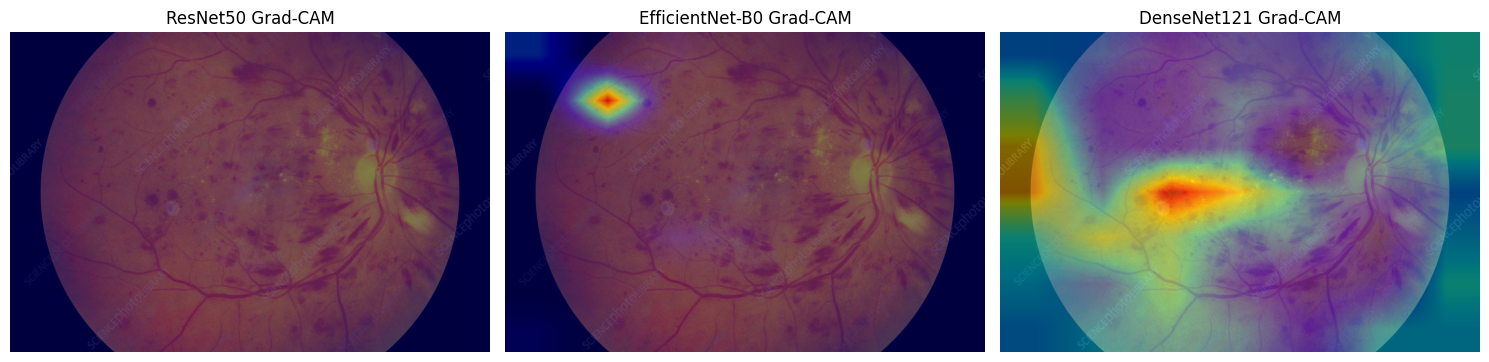

In [48]:
# ------------------------ Imports ------------------------
import torch
import torch.nn as nn
from torchvision import models, transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

# ------------------------ Define Your Fusion Model ------------------------
class FusionModelWithDR(nn.Module):
    def __init__(self, dr_out_dim=512):
        super(FusionModelWithDR, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()

        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier = nn.Identity()

        self.densenet = models.densenet121(pretrained=True)
        self.densenet.classifier = nn.Identity()

        self.fusion_input_dim = 2048 + 1280 + 1024

        self.dr = nn.Linear(self.fusion_input_dim, dr_out_dim)
        self.fusion_head = nn.Sequential(
            nn.Linear(dr_out_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        f1 = self.resnet(x)
        f2 = self.efficientnet(x)
        f3 = self.densenet(x)
        combined = torch.cat([f1, f2, f3], dim=1)
        reduced_features = self.dr(combined)
        return self.fusion_head(reduced_features)

# ------------------------ Load Model and Weights ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fusion_model_dr = FusionModelWithDR(dr_out_dim=1152).to(device)

# Path to your trained model weights
model_path = r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Code\fusion_model_dr_best_phase2.pth"
fusion_model_dr.load_state_dict(torch.load(model_path, map_location=device))
fusion_model_dr.eval()

# ------------------------ Load & Preprocess Image ------------------------
img_path = r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Demonstrate\DR.jpeg"

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

pil_img = Image.open(img_path).convert('RGB')
input_tensor = preprocess(pil_img).unsqueeze(0).to(device)

# ------------------------ Helper Function to Extract GradCAM ------------------------
def extract_gradcam_features(model_subnet, target_layer, input_tensor, feature_dim, device):
    """
    Apply GradCAM on a subnetwork (ResNet / EfficientNet / DenseNet) 
    with dummy FC head to simulate classification output.
    """
    model_subnet.eval()
    cam_extractor = GradCAM(model=model_subnet, target_layer=target_layer)

    # Forward pass through the backbone
    features = model_subnet(input_tensor)

    # Dummy classifier head to simulate logits
    dummy_fc = nn.Linear(feature_dim, 1).to(device)
    dummy_output = dummy_fc(features)

    # GradCAM extraction for class_idx = 0
    activation_map = cam_extractor(0, dummy_output)

    return activation_map[0].cpu()

# ------------------------ Grad-CAM Extraction for All Backbones ------------------------
cams = {}

# ResNet50
cams['resnet50'] = extract_gradcam_features(
    model_subnet=fusion_model_dr.resnet,
    target_layer=fusion_model_dr.resnet.layer4,
    input_tensor=input_tensor,
    feature_dim=2048,
    device=device
)

# EfficientNet-B0
cams['efficientnet_b0'] = extract_gradcam_features(
    model_subnet=fusion_model_dr.efficientnet,
    target_layer=fusion_model_dr.efficientnet.features[-1],
    input_tensor=input_tensor,
    feature_dim=1280,
    device=device
)

# DenseNet121
cams['densenet121'] = extract_gradcam_features(
    model_subnet=fusion_model_dr.densenet,
    target_layer=fusion_model_dr.densenet.features[-1],
    input_tensor=input_tensor,
    feature_dim=1024,
    device=device
)

# ------------------------ Visualization (Fixed) ------------------------
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

titles = ['ResNet50 Grad-CAM', 'EfficientNet-B0 Grad-CAM', 'DenseNet121 Grad-CAM']
for idx, (name, cam_map) in enumerate(cams.items()):
    # Ensure shape (H, W)
    cam_map_np = cam_map.squeeze().numpy()
    
    # Convert to PIL Image and resize
    cam_map_img = Image.fromarray(cam_map_np, mode='F')
    cam_map_resized = transforms.functional.resize(cam_map_img, pil_img.size)

    # Overlay CAM on original image
    result = overlay_mask(pil_img, cam_map_resized, alpha=0.5)

    axs[idx].imshow(result)
    axs[idx].axis('off')
    axs[idx].set_title(titles[idx], fontsize=12)

plt.tight_layout()
plt.show()





C:\Users\rafid\AppData\Local\Temp\ipykernel_18924\114155064.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fusion_model_dr.load_state_dict(torch.load(model_path, map_l

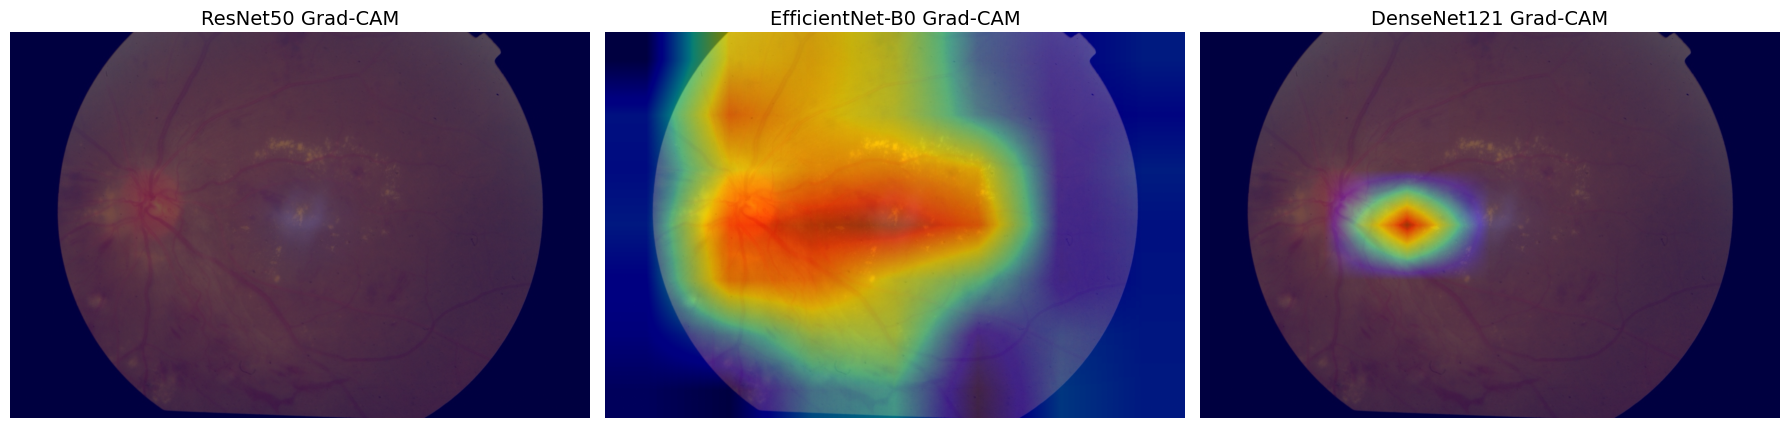

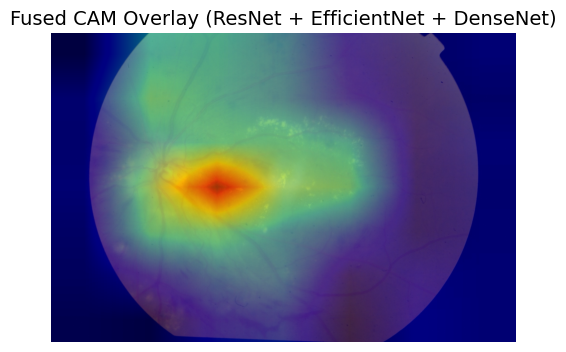

In [56]:
# ------------------------ Imports ------------------------
import torch
import torch.nn as nn
from torchvision import models, transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
import matplotlib.cm as cm

# ------------------------ Define Your Fusion Model ------------------------
class FusionModelWithDR(nn.Module):
    def __init__(self, dr_out_dim=512):
        super(FusionModelWithDR, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()

        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier = nn.Identity()

        self.densenet = models.densenet121(pretrained=True)
        self.densenet.classifier = nn.Identity()

        self.fusion_input_dim = 2048 + 1280 + 1024

        self.dr = nn.Linear(self.fusion_input_dim, dr_out_dim)
        self.fusion_head = nn.Sequential(
            nn.Linear(dr_out_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        f1 = self.resnet(x)
        f2 = self.efficientnet(x)
        f3 = self.densenet(x)
        combined = torch.cat([f1, f2, f3], dim=1)
        reduced_features = self.dr(combined)
        return self.fusion_head(reduced_features)

# ------------------------ Load Model and Weights ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fusion_model_dr = FusionModelWithDR(dr_out_dim=1152).to(device)

model_path = r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Code\fusion_model_dr_best_phase2.pth"
fusion_model_dr.load_state_dict(torch.load(model_path, map_location=device))
fusion_model_dr.eval()

# ------------------------ Load & Preprocess Image ------------------------
img_path = r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Data\Diabetic\APTOS_D_2f7789c1e046.png"

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

pil_img = Image.open(img_path).convert('RGB')
input_tensor = preprocess(pil_img).unsqueeze(0).to(device)

# ------------------------ Helper Function to Extract GradCAM ------------------------
def extract_gradcam_features(model_subnet, target_layer, input_tensor, feature_dim, device):
    model_subnet.eval()
    with torch.set_grad_enabled(True):  # Ensure gradients are tracked
        cam_extractor = GradCAM(model=model_subnet, target_layer=target_layer)

        # Forward pass through the backbone
        features = model_subnet(input_tensor)

        # Dummy classifier to simulate logits
        torch.manual_seed(42)
        dummy_fc = nn.Linear(feature_dim, 1).to(device)
        dummy_output = dummy_fc(features)

        activation_map = cam_extractor(0, dummy_output)
        return activation_map[0].cpu()

# ------------------------ Grad-CAM Extraction for All Backbones ------------------------
cams = {}

cams['resnet50'] = extract_gradcam_features(
    model_subnet=fusion_model_dr.resnet,
    target_layer=fusion_model_dr.resnet.layer4,
    input_tensor=input_tensor,
    feature_dim=2048,
    device=device
)

cams['efficientnet_b0'] = extract_gradcam_features(
    model_subnet=fusion_model_dr.efficientnet,
    target_layer=fusion_model_dr.efficientnet.features[-1],
    input_tensor=input_tensor,
    feature_dim=1280,
    device=device
)

cams['densenet121'] = extract_gradcam_features(
    model_subnet=fusion_model_dr.densenet,
    target_layer=fusion_model_dr.densenet.features[-1],
    input_tensor=input_tensor,
    feature_dim=1024,
    device=device
)

# ------------------------ Visualization of Individual CAMs ------------------------
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
titles = ['ResNet50 Grad-CAM', 'EfficientNet-B0 Grad-CAM', 'DenseNet121 Grad-CAM']

for idx, (name, cam_map) in enumerate(cams.items()):
    cam_map_np = cam_map.squeeze().numpy()

    # Normalize
    cam_map_np = (cam_map_np - cam_map_np.min()) / (cam_map_np.max() - cam_map_np.min() + 1e-8)

    # Resize and convert to color
    cam_map_img = Image.fromarray((cam_map_np * 255).astype(np.uint8)).resize(pil_img.size, resample=Image.BILINEAR)
    cam_map_color = cm.jet(np.array(cam_map_img) / 255.0)
    cam_map_color = (cam_map_color[:, :, :3] * 255).astype(np.uint8)

    # Overlay
    cam_overlay = Image.blend(pil_img, Image.fromarray(cam_map_color), alpha=0.5)

    axs[idx].imshow(cam_overlay)
    axs[idx].axis('off')
    axs[idx].set_title(titles[idx], fontsize=14)

plt.tight_layout()
plt.show()

# ------------------------ Fused Grad-CAM (Average) ------------------------
# Average the normalized CAMs
avg_cam = sum(cams[k].squeeze().cpu().numpy() for k in cams) / len(cams)
avg_cam = (avg_cam - avg_cam.min()) / (avg_cam.max() - avg_cam.min() + 1e-8)

# Resize and convert to color
avg_cam_img = Image.fromarray((avg_cam * 255).astype(np.uint8)).resize(pil_img.size, resample=Image.BILINEAR)
avg_cam_color = cm.jet(np.array(avg_cam_img) / 255.0)
avg_cam_color = (avg_cam_color[:, :, :3] * 255).astype(np.uint8)

# Overlay
composite_overlay = Image.blend(pil_img, Image.fromarray(avg_cam_color), alpha=0.5)

# Display
plt.figure(figsize=(6, 6))
plt.imshow(composite_overlay)
plt.axis('off')
plt.title('Fused CAM Overlay (ResNet + EfficientNet + DenseNet)', fontsize=14)
plt.show()


C:\Users\rafid\AppData\Local\Temp\ipykernel_18924\2827685915.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fusion_model_dr.load_state_dict(torch.load(model_path, map_

[ResNet50] CAM stats: min=0.0000, max=0.0000, mean=0.0000
[EfficientNet-B0] CAM stats: min=0.0000, max=1.0000, mean=0.2172
[DenseNet121] CAM stats: min=0.0000, max=1.0000, mean=0.2448


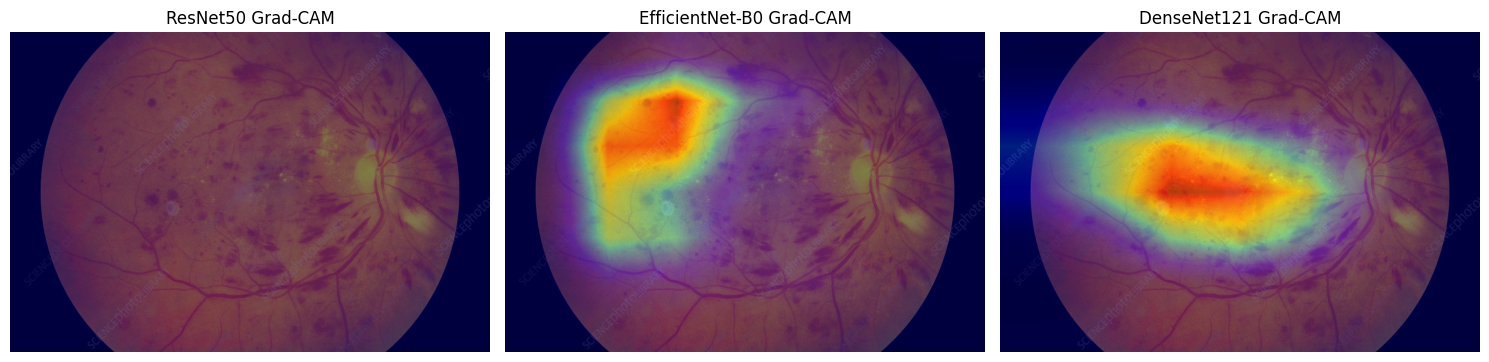

In [60]:
# ------------------------ Imports ------------------------
import torch
import torch.nn as nn
from torchvision import models, transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

# ------------------------ Define Your Fusion Model ------------------------
class FusionModelWithDR(nn.Module):
    def __init__(self, dr_out_dim=512):
        super(FusionModelWithDR, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()

        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier = nn.Identity()

        self.densenet = models.densenet121(pretrained=True)
        self.densenet.classifier = nn.Identity()

        self.fusion_input_dim = 2048 + 1280 + 1024

        self.dr = nn.Linear(self.fusion_input_dim, dr_out_dim)
        self.fusion_head = nn.Sequential(
            nn.Linear(dr_out_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        f1 = self.resnet(x)
        f2 = self.efficientnet(x)
        f3 = self.densenet(x)
        combined = torch.cat([f1, f2, f3], dim=1)
        reduced_features = self.dr(combined)
        return self.fusion_head(reduced_features)

# ------------------------ Load Model and Weights ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fusion_model_dr = FusionModelWithDR(dr_out_dim=1152).to(device)

# Path to your trained model weights
model_path = r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Code\fusion_model_dr_best_phase2.pth"
fusion_model_dr.load_state_dict(torch.load(model_path, map_location=device))
fusion_model_dr.eval()

# ------------------------ Load & Preprocess Image ------------------------
img_path = r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Demonstrate\DR.jpeg"

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

pil_img = Image.open(img_path).convert('RGB')
input_tensor = preprocess(pil_img).unsqueeze(0).to(device)
input_tensor.requires_grad = True  # Required for Grad-CAM

# ------------------------ Helper Function to Extract GradCAM ------------------------
def extract_gradcam_features(model_subnet, target_layer, input_tensor, feature_dim, device, name=""):
    """
    Apply GradCAM on a subnetwork and print CAM statistics for debugging.
    """
    model_subnet.eval()

    with torch.set_grad_enabled(True):
        try:
            cam_extractor = GradCAM(model=model_subnet, target_layer=target_layer)

            # Forward through subnet
            features = model_subnet(input_tensor)

            # Dummy head
            dummy_fc = nn.Linear(feature_dim, 1).to(device)
            dummy_fc.weight.requires_grad = True
            dummy_fc.bias.requires_grad = True

            dummy_output = dummy_fc(features)

            # Generate CAM
            activation_map = cam_extractor(0, dummy_output)
            cam = activation_map[0].detach().cpu()

            print(f"[{name}] CAM stats: min={cam.min():.4f}, max={cam.max():.4f}, mean={cam.mean():.4f}")
            return cam
        
        except Exception as e:
            print(f"[{name}] GradCAM extraction failed: {e}")
            return torch.zeros((1, 1))  # Return dummy tensor if failed

# ------------------------ Grad-CAM Extraction for All Backbones ------------------------
cams = {}

cams['resnet50'] = extract_gradcam_features(
    model_subnet=fusion_model_dr.resnet,
    target_layer=fusion_model_dr.resnet.layer4,
    input_tensor=input_tensor,
    feature_dim=2048,
    device=device,
    name="ResNet50"
)

cams['efficientnet_b0'] = extract_gradcam_features(
    model_subnet=fusion_model_dr.efficientnet,
    target_layer=fusion_model_dr.efficientnet.features[-1],
    input_tensor=input_tensor,
    feature_dim=1280,
    device=device,
    name="EfficientNet-B0"
)

cams['densenet121'] = extract_gradcam_features(
    model_subnet=fusion_model_dr.densenet,
    target_layer=fusion_model_dr.densenet.features,
    input_tensor=input_tensor,
    feature_dim=1024,
    device=device,
    name="DenseNet121"
)

# ------------------------ Visualization ------------------------
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

titles = ['ResNet50 Grad-CAM', 'EfficientNet-B0 Grad-CAM', 'DenseNet121 Grad-CAM']
for idx, (name, cam_map) in enumerate(cams.items()):
    cam_map_np = cam_map.squeeze().numpy()

    cam_map_img = Image.fromarray(cam_map_np, mode='F')
    cam_map_resized = transforms.functional.resize(cam_map_img, pil_img.size)

    result = overlay_mask(pil_img, cam_map_resized, alpha=0.5)

    axs[idx].imshow(result)
    axs[idx].axis('off')
    axs[idx].set_title(titles[idx], fontsize=12)

plt.tight_layout()
plt.show()


### Batch Grad-CAM

In [23]:
import torch
import torch.nn as nn
from torchvision import models, transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import gc

from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

# ------------------------ Define Your Fusion Model ------------------------
class FusionModelWithDR(nn.Module):
    def __init__(self, dr_out_dim=512):
        super(FusionModelWithDR, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()

        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier = nn.Identity()

        self.densenet = models.densenet121(pretrained=True)
        self.densenet.classifier = nn.Identity()

        self.fusion_input_dim = 2048 + 1280 + 1024

        self.dr = nn.Linear(self.fusion_input_dim, dr_out_dim)
        self.fusion_head = nn.Sequential(
            nn.Linear(dr_out_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # Binary classification (no sigmoid)
        )

    def forward(self, x):
        f1 = self.resnet(x)
        f2 = self.efficientnet(x)
        f3 = self.densenet(x)
        combined = torch.cat([f1, f2, f3], dim=1)
        reduced_features = self.dr(combined)
        return self.fusion_head(reduced_features)

# ------------------------ Load Model and Weights ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fusion_model_dr = FusionModelWithDR(dr_out_dim=1152).to(device)

# Path to your trained model weights
model_path = r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Code\fusion_model_dr_best_phase2.pth"
fusion_model_dr.load_state_dict(torch.load(model_path, map_location=device))
fusion_model_dr.eval()

# ------------------------ Preprocessing ------------------------
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# ------------------------ Target Layers ------------------------
target_layers = {
    "resnet50": fusion_model_dr.resnet.layer4,
    "efficientnet_b0": fusion_model_dr.efficientnet.features[-1],
    "densenet121": fusion_model_dr.densenet.features[-1]
}

# ------------------------ Visualization Function ------------------------
def visualize_and_save(cam, orig_img, save_path, title):
    """Overlay CAM and save"""
    orig_img_resized = orig_img.resize((224, 224))

    # Normalize cam to [0, 255]
    cam_img = cam.squeeze(0).numpy()
    cam_img = (cam_img - cam_img.min()) / (cam_img.max() - cam_img.min() + 1e-8)
    cam_img = np.uint8(255 * cam_img)

    # Convert to PIL grayscale image
    cam_pil = Image.fromarray(cam_img).convert("L")

    # Overlay heatmap on original image
    heatmap = overlay_mask(orig_img_resized, cam_pil, alpha=0.6)

    plt.figure(figsize=(6,6))
    plt.imshow(heatmap)
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

# ------------------------ Batch Grad-CAM Loop ------------------------

# Your folder of test images
img_dir = r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Demonstrate\GradCAM Test"  # CHANGE THIS PATH
img_paths = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Output dir
os.makedirs("./gradcam_results_batch", exist_ok=True)

for img_path in img_paths:
    pil_img = Image.open(img_path).convert('RGB')
    input_tensor = preprocess(pil_img).unsqueeze(0).to(device)

    # Store CAMs for this image
    cams = {}

    for name, layer in target_layers.items():
        cam_extractor = GradCAM(model=fusion_model_dr, target_layer=layer)

        # Forward pass
        out = fusion_model_dr(input_tensor)

        # Binary classifier → class_idx = 0
        activation_map = cam_extractor(0, out)

        # Store CAM
        cams[name] = activation_map[0].detach().cpu()

    # Save CAMs
    img_filename = os.path.splitext(os.path.basename(img_path))[0]
    for name, cam in cams.items():
        save_path = f"./gradcam_results_batch/{img_filename}_{name}_gradcam.png"
        visualize_and_save(cam, pil_img, save_path, f"{name.upper()} Grad-CAM")
        print(f"✅ Saved Grad-CAM for {img_filename} - {name} at {save_path}")

# ------------------------ Cleanup ------------------------
del fusion_model_dr
torch.cuda.empty_cache()
gc.collect()

C:\Users\rafid\AppData\Local\Temp\ipykernel_21348\59379411.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fusion_model_dr.load_state_dict(torch.load(model_path, map_lo

✅ Saved Grad-CAM for ODIR_D_4678_right - resnet50 at ./gradcam_results_batch/ODIR_D_4678_right_resnet50_gradcam.png
✅ Saved Grad-CAM for ODIR_D_4678_right - efficientnet_b0 at ./gradcam_results_batch/ODIR_D_4678_right_efficientnet_b0_gradcam.png
✅ Saved Grad-CAM for ODIR_D_4678_right - densenet121 at ./gradcam_results_batch/ODIR_D_4678_right_densenet121_gradcam.png
✅ Saved Grad-CAM for ODIR_D_4679_left - resnet50 at ./gradcam_results_batch/ODIR_D_4679_left_resnet50_gradcam.png
✅ Saved Grad-CAM for ODIR_D_4679_left - efficientnet_b0 at ./gradcam_results_batch/ODIR_D_4679_left_efficientnet_b0_gradcam.png
✅ Saved Grad-CAM for ODIR_D_4679_left - densenet121 at ./gradcam_results_batch/ODIR_D_4679_left_densenet121_gradcam.png
✅ Saved Grad-CAM for ODIR_D_4679_right - resnet50 at ./gradcam_results_batch/ODIR_D_4679_right_resnet50_gradcam.png
✅ Saved Grad-CAM for ODIR_D_4679_right - efficientnet_b0 at ./gradcam_results_batch/ODIR_D_4679_right_efficientnet_b0_gradcam.png
✅ Saved Grad-CAM for ODI

8363

## SHAP

In [64]:
import torch
import torch.nn as nn
from torchvision import models, transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import shap
import os
import gc

# ------------------------ Define Your Fusion Model ------------------------
class FusionModelWithDR(nn.Module):
    def __init__(self, dr_out_dim=512):
        super(FusionModelWithDR, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()

        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier = nn.Identity()

        self.densenet = models.densenet121(pretrained=True)
        self.densenet.classifier = nn.Identity()

        self.fusion_input_dim = 2048 + 1280 + 1024

        self.dr = nn.Linear(self.fusion_input_dim, dr_out_dim)
        self.fusion_head = nn.Sequential(
            nn.Linear(dr_out_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # Binary classification (no sigmoid)
        )

    def forward(self, x):
        f1 = self.resnet(x)
        f2 = self.efficientnet(x)
        f3 = self.densenet(x)
        combined = torch.cat([f1, f2, f3], dim=1)
        reduced_features = self.dr(combined)
        return self.fusion_head(reduced_features)

# ------------------------ Load Model and Weights ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fusion_model_dr = FusionModelWithDR(dr_out_dim=1152).to(device)
model_path = r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Code\fusion_model_dr_best_phase2.pth"
fusion_model_dr.load_state_dict(torch.load(model_path, map_location=device))
fusion_model_dr.eval()

# ------------------------ Preprocessing ------------------------
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# ------------------------ Load Sample Images ------------------------
img_dir = r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Demonstrate\GradCAM Test"
img_paths = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

# We'll only explain a small batch (like 2) to keep SHAP fast
img_paths_sample = img_paths[:2]

input_tensors = []
pil_imgs = []

for img_path in img_paths_sample:
    pil_img = Image.open(img_path).convert('RGB')
    pil_imgs.append(pil_img)
    input_tensor = preprocess(pil_img)
    input_tensors.append(input_tensor)

input_tensor_batch = torch.stack(input_tensors).to(device)  # shape (B, 3, 224, 224)

# ------------------------ SHAP GradientExplainer ------------------------

# Use a small random background for baseline (just reuse the 2 images)
background = input_tensor_batch[:2]

explainer = shap.GradientExplainer(fusion_model_dr, background)

# Compute SHAP values for batch
shap_values, indexes = explainer.shap_values(input_tensor_batch, nsamples=10)

# ------------------------ Visualize and Save ------------------------
os.makedirs("./shap_results", exist_ok=True)

for i, (img, shap_val) in enumerate(zip(pil_imgs, shap_values)):  # <-- Fixed (no [0])

    # Convert SHAP to numpy (3, 224, 224)
    shap_img = shap_val

    # Aggregate over channels → shape (224, 224)
    shap_agg = np.abs(shap_img).mean(0)

    # Normalize heatmap
    shap_agg = (shap_agg - shap_agg.min()) / (shap_agg.max() - shap_agg.min() + 1e-8)

    # Resize original img
    orig_img_resized = img.resize((224, 224))

    # Convert SHAP to grayscale PIL
    shap_uint8 = np.uint8(255 * shap_agg)
    shap_pil = Image.fromarray(shap_uint8).convert("L")

    # Overlay SHAP heatmap on image
    from torchcam.utils import overlay_mask
    heatmap = overlay_mask(orig_img_resized, shap_pil, alpha=0.6)

    save_path = f"./shap_results/image_{i}_shap.png"
    plt.figure(figsize=(6,6))
    plt.imshow(heatmap)
    plt.axis('off')
    plt.title(f"SHAP Explanation - Image {i}")
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

    print(f"✅ Saved SHAP explanation for image {i} at {save_path}")

# ------------------------ Cleanup ------------------------
#del fusion_model_dr
#torch.cuda.empty_cache()
#gc.collect()

C:\Users\rafid\AppData\Local\Temp\ipykernel_18924\2382953718.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fusion_model_dr.load_state_dict(torch.load(model_path, map_

✅ Saved SHAP explanation for image 0 at ./shap_results/image_0_shap.png
✅ Saved SHAP explanation for image 1 at ./shap_results/image_1_shap.png


### Test 1 unsuccessful

In [67]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import shap

# ------------------------ Fusion Model ------------------------
class FusionModelWithDR(nn.Module):
    def __init__(self, dr_out_dim=512):
        super(FusionModelWithDR, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()

        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier = nn.Identity()

        self.densenet = models.densenet121(pretrained=True)
        self.densenet.classifier = nn.Identity()

        self.fusion_input_dim = 2048 + 1280 + 1024

        self.dr = nn.Linear(self.fusion_input_dim, dr_out_dim)
        self.fusion_head = nn.Sequential(
            nn.Linear(dr_out_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        f1 = self.resnet(x)
        f2 = self.efficientnet(x)
        f3 = self.densenet(x)
        combined = torch.cat([f1, f2, f3], dim=1)
        reduced_features = self.dr(combined)
        return self.fusion_head(reduced_features)

# Wrap model to apply sigmoid for SHAP
class WrappedFusionModel(nn.Module):
    def __init__(self, base_model):
        super(WrappedFusionModel, self).__init__()
        self.base_model = base_model

    def forward(self, x):
        return torch.sigmoid(self.base_model(x))

# ------------------------ Load Model ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fusion_model_dr = FusionModelWithDR(dr_out_dim=1152).to(device)
model_path = r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Code\fusion_model_dr_best_phase2.pth"
fusion_model_dr.load_state_dict(torch.load(model_path, map_location=device))
fusion_model_dr.eval()

wrapped_model = WrappedFusionModel(fusion_model_dr)

# ------------------------ Preprocessing ------------------------
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ------------------------ Load Images ------------------------
img_dir = r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Demonstrate\GradCAM Test"
img_paths = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
img_paths_sample = img_paths[:2]  # Use first 2

input_tensors = []
pil_imgs = []
for img_path in img_paths_sample:
    pil_img = Image.open(img_path).convert('RGB')
    pil_imgs.append(pil_img)
    input_tensor = preprocess(pil_img)
    input_tensors.append(input_tensor)

input_tensor_batch = torch.stack(input_tensors).to(device)

# ------------------------ SHAP Explainer ------------------------
background = input_tensor_batch[:2]
explainer = shap.GradientExplainer(wrapped_model, background)

shap_values, indexes = explainer.shap_values(input_tensor_batch, nsamples=10)


C:\Users\rafid\AppData\Local\Temp\ipykernel_18924\857981185.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fusion_model_dr.load_state_dict(torch.load(model_path, map_l

In [69]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

os.makedirs("./shap_results", exist_ok=True)

for i, (img, shap_val) in enumerate(zip(pil_imgs, shap_values)):

    shap_agg = np.abs(shap_val).mean(0)  # shape: (224, 224)
    print(f"[Image {i}] SHAP stats: min={shap_agg.min():.4f}, max={shap_agg.max():.4f}, mean={shap_agg.mean():.4f}")

    if shap_agg.max() == 0:
        print(f"⚠️ Image {i} has all-zero SHAP values — skipping overlay.")
        continue

    # Normalize
    shap_agg = (shap_agg - shap_agg.min()) / (shap_agg.max() - shap_agg.min() + 1e-8)

    # Resize original image
    orig_img_resized = img.resize((224, 224)).convert("RGB")
    orig_np = np.array(orig_img_resized).astype(np.float32) / 255.0

    # Apply colormap
    cmap = cm.get_cmap("jet")
    shap_rgb = cmap(shap_agg)[..., :3]  # Get RGB only
    shap_rgb = np.clip(shap_rgb, 0, 1)

    # Blend original image with SHAP heatmap
    alpha = 0.5
    overlay = (alpha * shap_rgb + (1 - alpha) * orig_np)
    overlay_uint8 = np.uint8(overlay * 255)

    # Save result
    save_path = f"./shap_results/image_{i}_shap.png"
    Image.fromarray(overlay_uint8).save(save_path)
    print(f"✅ Saved SHAP explanation for image {i} at {save_path}")



[Image 0] SHAP stats: min=0.0000, max=0.0001, mean=0.0000
✅ Saved SHAP explanation for image 0 at ./shap_results/image_0_shap.png
[Image 1] SHAP stats: min=0.0000, max=0.0000, mean=0.0000
✅ Saved SHAP explanation for image 1 at ./shap_results/image_1_shap.png


C:\Users\rafid\AppData\Local\Temp\ipykernel_18924\1807077110.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("jet")


### Test 2 

In [72]:
# ------------------------ Imports ------------------------
import torch
import torch.nn as nn
from torchvision import models, transforms
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import shap
from torchcam.utils import overlay_mask
import matplotlib.cm as cm

# ------------------------ Define Your Fusion Model with Sigmoid ------------------------
class FusionModelWithDR(nn.Module):
    def __init__(self, dr_out_dim=512):
        super(FusionModelWithDR, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()

        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier = nn.Identity()

        self.densenet = models.densenet121(pretrained=True)
        self.densenet.classifier = nn.Identity()

        self.fusion_input_dim = 2048 + 1280 + 1024

        self.dr = nn.Linear(self.fusion_input_dim, dr_out_dim)
        self.fusion_head = nn.Sequential(
            nn.Linear(dr_out_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()  # Added for SHAP compatibility
        )

    def forward(self, x):
        f1 = self.resnet(x)
        f2 = self.efficientnet(x)
        f3 = self.densenet(x)
        combined = torch.cat([f1, f2, f3], dim=1)
        reduced_features = self.dr(combined)
        return self.fusion_head(reduced_features)

# ------------------------ Load Model and Weights ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fusion_model_dr = FusionModelWithDR(dr_out_dim=1152).to(device)
model_path = r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Code\fusion_model_dr_best_phase2.pth"
fusion_model_dr.load_state_dict(torch.load(model_path, map_location=device))
fusion_model_dr.eval()

# ------------------------ Preprocessing ------------------------
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# ------------------------ Load Sample Images ------------------------
img_dir = r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Demonstrate\GradCAM Test"
img_paths = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Select a few images for SHAP
img_paths_sample = img_paths[:2]

input_tensors = []
pil_imgs = []

for img_path in img_paths_sample:
    pil_img = Image.open(img_path).convert('RGB')
    pil_imgs.append(pil_img)
    input_tensor = preprocess(pil_img)
    input_tensors.append(input_tensor)

input_tensor_batch = torch.stack(input_tensors).to(device)  # shape (B, 3, 224, 224)

# ------------------------ SHAP GradientExplainer ------------------------

# Use the input batch itself as background
background = input_tensor_batch[:2]

explainer = shap.GradientExplainer(fusion_model_dr, background)

# Compute SHAP values for batch
shap_values, indexes = explainer.shap_values(input_tensor_batch, nsamples=10)

# ------------------------ Visualize and Save ------------------------
os.makedirs("./shap_results", exist_ok=True)

for i, (img, shap_val) in enumerate(zip(pil_imgs, shap_values)):
    # shap_val shape: (3, 224, 224)
    shap_agg = np.abs(shap_val).mean(0)  # (224, 224)
    print(f"[Image {i}] SHAP stats: min={shap_agg.min():.4f}, max={shap_agg.max():.4f}, mean={shap_agg.mean():.4f}")

    # Normalize heatmap
    if shap_agg.max() > 0:
        shap_norm = (shap_agg - shap_agg.min()) / (shap_agg.max() - shap_agg.min() + 1e-8)
    else:
        shap_norm = shap_agg

   # Convert SHAP heatmap to grayscale image
    shap_uint8 = np.uint8(255 * shap_norm)
    shap_pil = Image.fromarray(shap_uint8).convert("L")

    # Resize original image
    orig_img_resized = img.resize((224, 224))

    # Overlay using torchcam's default colormap
    heatmap = overlay_mask(orig_img_resized, shap_pil, alpha=0.6)


    # Save and show
    save_path = f"./shap_results/image_{i}_shap.png"
    plt.figure(figsize=(6, 6))
    plt.imshow(heatmap)
    plt.axis('off')
    plt.title(f"SHAP Explanation - Image {i}")
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

    print(f"✅ Saved SHAP explanation for image {i} at {save_path}")


C:\Users\rafid\AppData\Local\Temp\ipykernel_18924\3629652644.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fusion_model_dr.load_state_dict(torch.load(model_path, map_

[Image 0] SHAP stats: min=0.0000, max=0.0000, mean=0.0000
✅ Saved SHAP explanation for image 0 at ./shap_results/image_0_shap.png
[Image 1] SHAP stats: min=0.0000, max=0.0000, mean=0.0000
✅ Saved SHAP explanation for image 1 at ./shap_results/image_1_shap.png


## LIME

In [75]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np

# ------------------------ Helper: PyTorch model wrapper for LIME ------------------------
def predict_numpy(images):
    """
    LIME expects a function that takes a list of numpy images and returns
    probability predictions. We'll convert numpy → torch → model → sigmoid → numpy probs
    """
    fusion_model_dr.eval()
    batch = []

    for img in images:
        pil_img = Image.fromarray(img)
        tensor_img = preprocess(pil_img).unsqueeze(0)  # shape (1, 3, 224, 224)
        batch.append(tensor_img)

    batch_tensor = torch.cat(batch).to(device)

    with torch.no_grad():
        logits = fusion_model_dr(batch_tensor)
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()

    # LIME expects shape (n_samples, n_classes)
    probs = np.stack([1 - probs, probs], axis=1)  # shape (N, 2)
    return probs

# ------------------------ Instantiate LIME explainer ------------------------
explainer = lime_image.LimeImageExplainer()

# ------------------------ Run LIME on sample images ------------------------
os.makedirs("./lime_results", exist_ok=True)

for i, pil_img in enumerate(pil_imgs):
    img_np = np.array(pil_img.resize((224, 224)))

    explanation = explainer.explain_instance(
        image=img_np,
        classifier_fn=predict_numpy,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    # Get predicted label dynamically
    predicted_label = explanation.top_labels[0]

    temp, mask = explanation.get_image_and_mask(
        label=predicted_label,
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    heatmap = mark_boundaries(temp, mask)

    save_path = f"./lime_results/image_{i}_lime.png"
    plt.figure(figsize=(6,6))
    plt.imshow(heatmap)
    plt.axis('off')
    plt.title(f"LIME Explanation - Image {i}")
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

    print(f"✅ Saved LIME explanation for image {i} at {save_path}")


100%|██████████| 1000/1000 [00:23<00:00, 42.33it/s]


✅ Saved LIME explanation for image 0 at ./lime_results/image_0_lime.png


100%|██████████| 1000/1000 [00:24<00:00, 40.22it/s]


✅ Saved LIME explanation for image 1 at ./lime_results/image_1_lime.png


# Demonstration

In [25]:
import torch
import torch.nn as nn
from torchvision import models
import gc

# ------------------------ Fusion Model Definition with Dimensionality Reduction ------------------------
class FusionModelWithDR(nn.Module):
    def __init__(self, dr_out_dim=512):  # Added parameter for DR output dimension
        super(FusionModelWithDR, self).__init__()

        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()

        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier = nn.Identity()

        self.densenet = models.densenet121(pretrained=True)
        self.densenet.classifier = nn.Identity()

        self.fusion_input_dim = 2048 + 1280 + 1024

        # Dimensionality Reduction layer
        self.dr = nn.Linear(self.fusion_input_dim, dr_out_dim)
        self.dr_out_dim = dr_out_dim

        self.fusion_head = nn.Sequential(
            nn.Linear(self.dr_out_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # No sigmoid for binary classification with BCEWithLogitsLoss
        )

    def forward(self, x):
        f1 = self.resnet(x)
        f2 = self.efficientnet(x)
        f3 = self.densenet(x)

        combined = torch.cat([f1, f2, f3], dim=1)
        reduced_features = self.dr(combined)
        return self.fusion_head(reduced_features)

# ------------------------ Instantiate Model and Load State Dict ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Match this to the saved model's DR output dimension
dr_output_dimension = 1152
fusion_model_dr = FusionModelWithDR(dr_output_dimension).to(device)

# Load the saved weights
state_dict = torch.load("fusion_model_dr_best_phase2.pth", map_location=device)
fusion_model_dr.load_state_dict(state_dict)

# Set to eval mode
fusion_model_dr.eval()


c:\Users\rafid\.conda\envs\torch_on\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rafid\.conda\envs\torch_on\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\rafid\.conda\envs\torch_on\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=Efficien

FusionModelWithDR(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [28]:
from torchvision import transforms
from PIL import Image

# Preprocessing transformation (ImageNet-standard)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

# Path to your image
image_path = r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Demonstrate\mine.jpg"

# Load and preprocess image
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Inference
with torch.no_grad():
    output = fusion_model_dr(input_tensor)
    prediction = (output > 0.5).float()

# Display result
if prediction.item() == 0:
    print("Prediction: Diabetic")
else:
    print("Prediction: Normal")


Prediction: Normal


# Inference time per image comparison

In [104]:
import torch
import time
from torchvision import transforms
from PIL import Image
import os
import numpy as np

# ----------------------------- Step 1: Setup -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------- Step 2: Preprocessing -----------------------------
# Folder containing multiple test images
image_folder = r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Reserve Dataset\Diabetic_reduced_1000"

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert("RGB")
            img_tensor = preprocess(img).unsqueeze(0)  # shape: (1, 3, 224, 224)
            images.append(img_tensor)
    return images

image_tensors = load_images_from_folder(image_folder)
print(f"🖼️ Loaded {len(image_tensors)} images from {image_folder}")
image_tensors = [img.to(device) for img in image_tensors]

# ----------------------------- Step 3: Timing Function -----------------------------
def measure_inference_time(model, image_tensors, warmup=10, trials=1):
    model.eval()
    model.to(device)

    # Warm-up on one image
    with torch.no_grad():
        for _ in range(warmup):
            _ = model(image_tensors[0])
    if torch.cuda.is_available():
        torch.cuda.synchronize()

    times = []

    with torch.no_grad():
        for _ in range(trials):
            for img in image_tensors:
                start = time.perf_counter()
                _ = model(img)
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                end = time.perf_counter()
                times.append(end - start)

    return np.mean(times), np.std(times)

# ----------------------------- Step 4: Load Models & Compare -----------------------------
# from your_model_file import FusionModelWithDR  # Replace with actual model class

model_paths = {
    "fusion_model_dr_best_phase2": r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Code\fusion_model_dr_best_phase2.pth",
    "efficientnet_b0_best_model": r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Code\efficientnet_b0_best_model.pth",
    "densenet_best_model": r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Code\densenet_best_model.pth",
    "resnet50_best_model": r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Code\resnet50_best_model.pth",
    #"fusion_best_model": r"C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Code\fusion_best_model.pth"
}

results = {}

for name, path in model_paths.items():
    print(f"\n🔄 Loading model: {name}")

    if name == "fusion_model_dr_best_phase2":
        model = FusionModelWithDR(dr_out_dim=1152)
    elif name == "resnet50_best_model":
        model = resnet50  # already defined and customized earlier
    elif name == "densenet_best_model":
        model = densenet
    elif name == "efficientnet_b0_best_model":
        model = efficientnet
    #elif name == "fusion_best_model":
        #model = FusionModel()
    else:
        raise ValueError(f"Unknown model name: {name}")

    model.load_state_dict(torch.load(path, map_location=device))

    avg_time, std_time = measure_inference_time(model, image_tensors)
    results[name] = (avg_time, std_time)
    print(f"✅ {name} avg inference time: {avg_time * 1000:.2f} ms ± {std_time * 1000:.2f}")


🖼️ Loaded 1000 images from C:\Users\rafid\OneDrive\Documents\Python Script for Image Processing\RETINA\Reserve Dataset\Diabetic_reduced_1000

🔄 Loading model: fusion_model_dr_best_phase2


C:\Users\rafid\AppData\Local\Temp\ipykernel_18924\3308296935.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device)

✅ fusion_model_dr_best_phase2 avg inference time: 105.38 ms ± 26.42

🔄 Loading model: efficientnet_b0_best_model
✅ efficientnet_b0_best_model avg inference time: 30.70 ms ± 8.59

🔄 Loading model: densenet_best_model
✅ densenet_best_model avg inference time: 53.40 ms ± 14.85

🔄 Loading model: resnet50_best_model
✅ resnet50_best_model avg inference time: 20.37 ms ± 4.83


C:\Users\rafid\AppData\Local\Temp\ipykernel_18924\2609894996.py:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


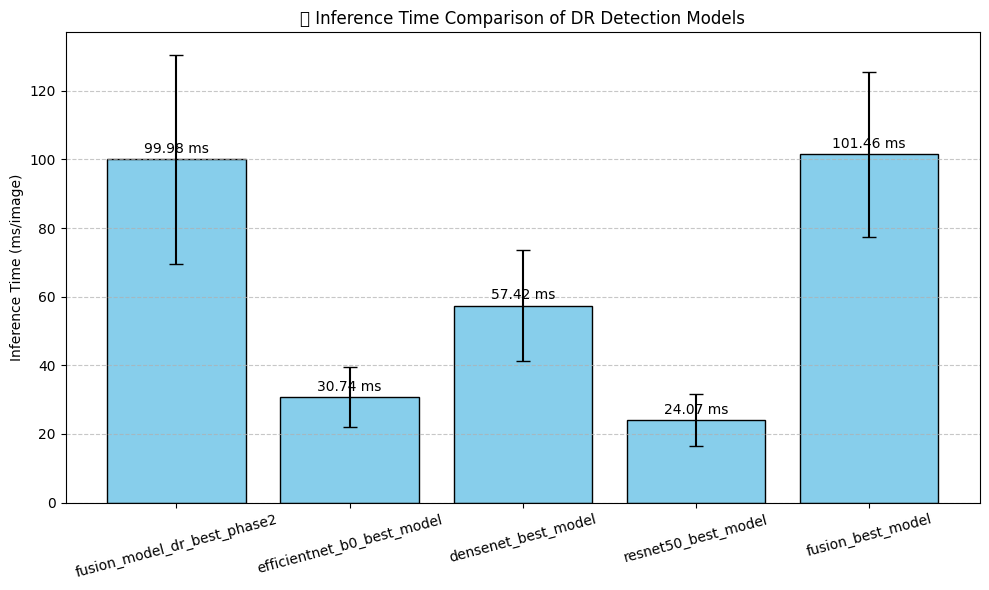

In [101]:
import matplotlib.pyplot as plt

# Prepare data for plotting
model_names = list(results.keys())
avg_times_ms = [avg * 1000 for avg, _ in results.values()]
std_times_ms = [std * 1000 for _, std in results.values()]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, avg_times_ms, yerr=std_times_ms, capsize=5, color='skyblue', edgecolor='black')

# Add value labels on top
for bar, avg in zip(bars, avg_times_ms):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{avg:.2f} ms', ha='center', va='bottom', fontsize=10)

plt.ylabel("Inference Time (ms/image)")
plt.title("📊 Inference Time Comparison of DR Detection Models")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



🔄 Loading model: fusion_model_dr_best_phase2


C:\Users\rafid\AppData\Local\Temp\ipykernel_18924\4294561095.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device)

✅ fusion_model_dr_best_phase2: Mean 94.31 ms, Std 19.88 ms

🔄 Loading model: efficientnet_b0_best_model
✅ efficientnet_b0_best_model: Mean 25.81 ms, Std 6.73 ms

🔄 Loading model: densenet_best_model
✅ densenet_best_model: Mean 45.92 ms, Std 9.34 ms

🔄 Loading model: resnet50_best_model
✅ resnet50_best_model: Mean 18.69 ms, Std 4.25 ms


C:\Users\rafid\AppData\Local\Temp\ipykernel_18924\4294561095.py:57: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


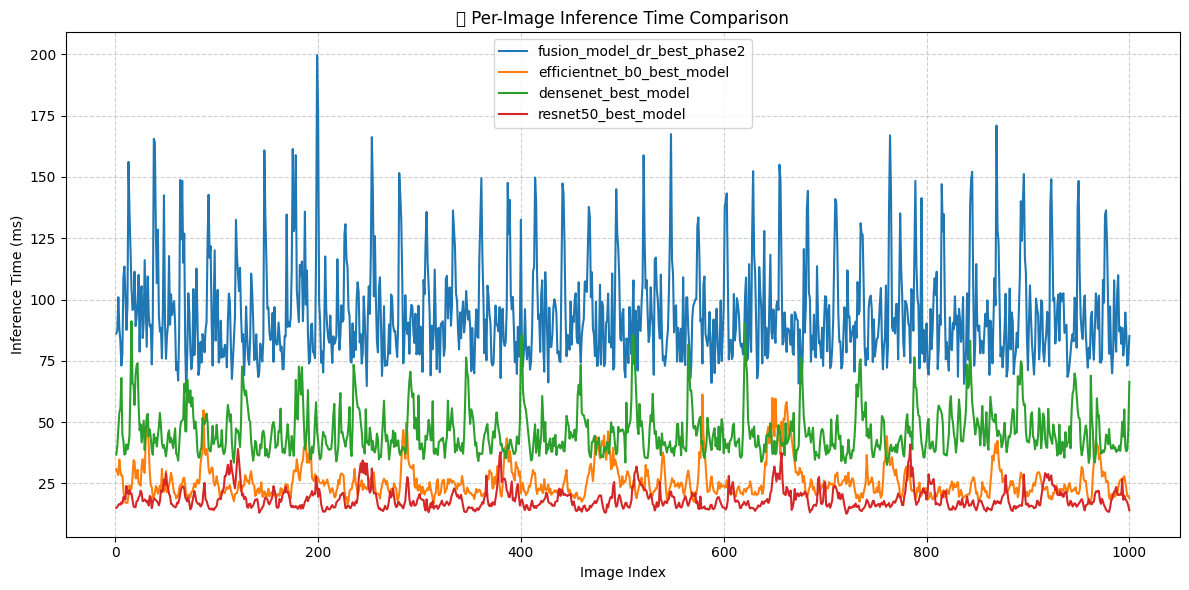

In [105]:
def measure_inference_time_per_image(model, image_tensors, warmup=10):
    model.eval()
    model.to(device)

    # Warm-up
    with torch.no_grad():
        for _ in range(warmup):
            _ = model(image_tensors[0])
    if torch.cuda.is_available():
        torch.cuda.synchronize()

    times = []

    with torch.no_grad():
        for img in image_tensors:
            start = time.perf_counter()
            _ = model(img)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            end = time.perf_counter()
            times.append((end - start) * 1000)  # convert to milliseconds

    return times

all_image_times = {}

for name, path in model_paths.items():
    print(f"\n🔄 Loading model: {name}")

    if name == "fusion_model_dr_best_phase2":
        model = FusionModelWithDR(dr_out_dim=1152)
    elif name == "resnet50_best_model":
        model = resnet50
    elif name == "densenet_best_model":
        model = densenet
    elif name == "efficientnet_b0_best_model":
        model = efficientnet
    else:
        raise ValueError(f"Unknown model name: {name}")

    model.load_state_dict(torch.load(path, map_location=device))

    per_image_times = measure_inference_time_per_image(model, image_tensors)
    all_image_times[name] = per_image_times
    print(f"✅ {name}: Mean {np.mean(per_image_times):.2f} ms, Std {np.std(per_image_times):.2f} ms")

plt.figure(figsize=(12, 6))

for name, times in all_image_times.items():
    plt.plot(range(1, len(times)+1), times, label=name)

plt.xlabel("Image Index")
plt.ylabel("Inference Time (ms)")
plt.title("📈 Per-Image Inference Time Comparison")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Interpretetion new

## GradCAM

In [19]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import transforms
import torch
import cv2
import numpy as np
from PIL import Image

# Ensure you use the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and move your model to device
model = resnet50.to(device)
model.load_state_dict(torch.load('resnet50_best_model.pth', map_location=device))
model.eval()

# Target layer for ResNet50
target_layer = model.layer4[-1]

# Load and preprocess image
image = Image.open("DR.jpeg").convert('RGB')
rgb_img = np.array(image.resize((224, 224))) / 255.0  # For heatmap overlay

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
input_tensor = transform(image).unsqueeze(0).to(device)

# Initialize GradCAM
cam = GradCAM(model=model, target_layers=[target_layer])

# Compute CAM
grayscale_cam = cam(input_tensor=input_tensor)[0]  # [0] for first (and only) image

# Overlay heatmap
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# Save result
cv2.imwrite("resnet50_cam.jpg", cv2.cvtColor(visualization, cv2.COLOR_RGB2BGR))


C:\Users\rafid\AppData\Local\Temp\ipykernel_23024\2817999546.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet50_best_model.pth',

True

In [111]:
from captum.attr import IntegratedGradients
import torch
import matplotlib.pyplot as plt

# Load image and prepare input
input_tensor = transform(image).unsqueeze(0).to(device)
input_tensor.requires_grad = True

# Load trained fusion model
fusion_model_dr.load_state_dict(torch.load("fusion_model_dr_best_phase2.pth", map_location=device))
fusion_model_dr.eval().to(device)

# Use Integrated Gradients
ig = IntegratedGradients(fusion_model_dr)
attributions, delta = ig.attribute(input_tensor, target=0, return_convergence_delta=True)  # 0 = Normal, 1 = Diabetic

# Visualize
attr = attributions.squeeze().cpu().detach().numpy()
attr = np.transpose(attr, (1, 2, 0))  # [H, W, C]

# Normalize for display
attr = (attr - attr.min()) / (attr.max() - attr.min())

# Show heatmap
plt.imshow(rgb_img)
plt.imshow(attr, cmap="jet", alpha=0.5)
plt.title("Integrated Gradients on Fusion Model")
plt.axis("off")
plt.savefig("fusion_ig_heatmap.png")
plt.show()


C:\Users\rafid\AppData\Local\Temp\ipykernel_18924\4272234968.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fusion_model_dr.load_state_dict(torch.load("fusion_model_dr

OutOfMemoryError: CUDA out of memory. Tried to allocate 78.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 11.96 GiB is allocated by PyTorch, and 664.75 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## LIME

C:\Users\rafid\AppData\Local\Temp\ipykernel_16860\3732752284.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fusion_model_dr.load_state_dict(torch.load("fusion_model_dr

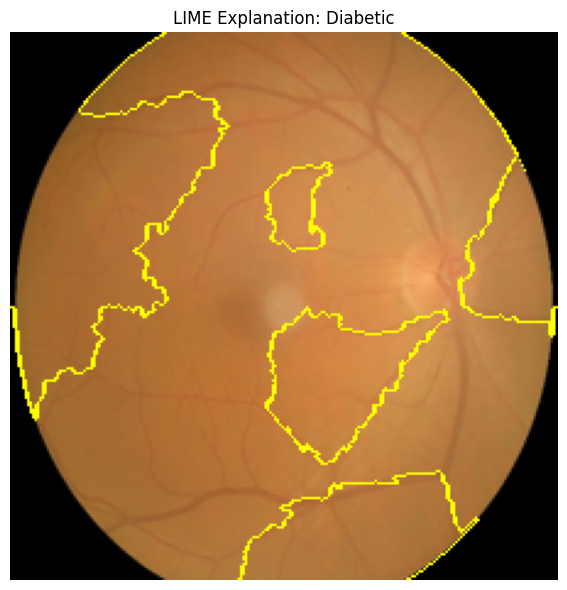

In [24]:
import torch
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from torchvision import models
from skimage.color import label2rgb

# -------------------- Device and Model Setup --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your trained fusion model
fusion_model_dr.load_state_dict(torch.load("fusion_model_dr_best_phase2.pth", map_location=device))
fusion_model_dr.eval().to(device)

# -------------------- Define Prediction Function --------------------
def predict_fn(images_np):
    """
    Takes a batch of images in numpy format (HWC, values in [0, 1]),
    normalizes and returns probabilities in the order: [Diabetic (0), Normal (1)].
    """
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    tensor_batch = torch.stack([
        preprocess((img * 255).astype(np.uint8)) for img in images_np
    ])
    tensor_batch = tensor_batch.to(device)

    with torch.no_grad():
        logits = fusion_model_dr(tensor_batch).squeeze(1)  # [batch]
        probs_normal = torch.sigmoid(logits).cpu().numpy()  # Probabilities for class 1 (Normal)
        probs_diabetic = 1 - probs_normal  # Invert for Diabetic class (0)

    # Return [Diabetic, Normal]
    return np.stack([probs_diabetic, probs_normal], axis=1)

# -------------------- Load and Preprocess Image --------------------
image_path = "ODIR_D_4690_right.jpg"  # Replace with your image
original_image = Image.open(image_path).convert("RGB").resize((224, 224))
image_np = np.array(original_image) / 255.0  # Normalize to [0, 1]

# -------------------- LIME Explanation --------------------
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    image_np,
    classifier_fn=predict_fn,
    top_labels=2,
    hide_color=0,
    num_samples=1000  # More samples → more stable explanation
)

from skimage.segmentation import mark_boundaries

# -------------------- Get LIME mask and temp image --------------------
label_to_show = 0  # 0 = Diabetic

temp, mask = explanation.get_image_and_mask(
    label=label_to_show,
    positive_only=True,     # Only show features supporting the prediction
    num_features=10,        # More superpixels = more interpretability
    hide_rest=False         # Set to False to show the whole image
)

# -------------------- Fix visualization issue --------------------
# If temp looks black, normalize to [0, 1] or ensure dtype is correct
if temp.dtype != np.uint8:
    temp = (temp * 255).astype(np.uint8)

# Display overlay
plt.figure(figsize=(6, 6))
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"LIME Explanation: {'Diabetic' if label_to_show == 0 else 'Normal'}")
plt.axis("off")
plt.tight_layout()
plt.savefig("lime_fusion_diabetic_explanation.png")
plt.show()



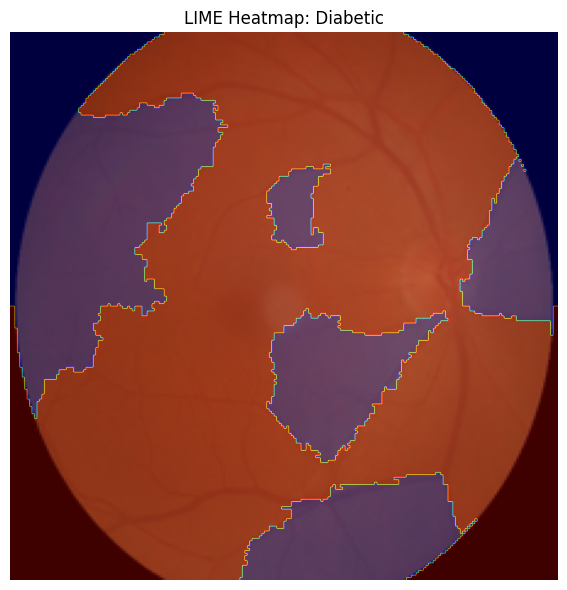

In [25]:
import matplotlib.pyplot as plt
from skimage.color import label2rgb
import numpy as np

# -------------------- Get the mask and scores --------------------
label_to_show = 0  # 0 = Diabetic

# Get LIME explanation
temp, mask = explanation.get_image_and_mask(
    label=label_to_show,
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# Get image + superpixel weights as a dict: {segment_id: importance_score}
dict_heatmap = dict(explanation.local_exp[label_to_show])  # {superpixel_index: weight}

# Create an empty heatmap and fill with importance values
heatmap = np.zeros(mask.shape, dtype=np.float32)
for seg_val, score in dict_heatmap.items():
    heatmap[mask == seg_val] = score

# Normalize heatmap to [0, 1]
heatmap -= heatmap.min()
heatmap /= (heatmap.max() + 1e-6)

# Resize original image (just to make sure it's uint8)
original_display = (image_np * 255).astype(np.uint8)

# Overlay heatmap on original image using alpha blending
plt.figure(figsize=(6, 6))
plt.imshow(original_display)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Heatmap overlay
plt.title(f"LIME Heatmap: {'Diabetic' if label_to_show == 0 else 'Normal'}")
plt.axis("off")
plt.tight_layout()
plt.savefig("lime_heatmap_diabetic.png")
plt.show()


In [ ]:
import os
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# -------------------- Paths --------------------
input_folder = "images/"
output_folder = "lime_heatmaps/"
os.makedirs(output_folder, exist_ok=True)

# -------------------- Device and Model --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fusion_model_dr.load_state_dict(torch.load("fusion_model_dr_best_phase2.pth", map_location=device))
fusion_model_dr.eval().to(device)

# -------------------- Prediction Function for LIME --------------------
def predict_fn(images_np):
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    tensor_batch = torch.stack([
        preprocess((img * 255).astype(np.uint8)) for img in images_np
    ])
    tensor_batch = tensor_batch.to(device)

    with torch.no_grad():
        logits = fusion_model_dr(tensor_batch).squeeze(1)
        probs_normal = torch.sigmoid(logits).cpu().numpy()
        probs_diabetic = 1 - probs_normal

    return np.stack([probs_diabetic, probs_normal], axis=1)

# -------------------- LIME Explainer --------------------
explainer = lime_image.LimeImageExplainer()

# -------------------- Process All Images --------------------
for filename in os.listdir(input_folder):
    if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    image_path = os.path.join(input_folder, filename)
    image = Image.open(image_path).convert("RGB").resize((224, 224))
    image_np = np.array(image) / 255.0

    # Get LIME explanation
    explanation = explainer.explain_instance(
        image_np,
        classifier_fn=predict_fn,
        top_labels=2,
        hide_color=0,
        num_samples=1000
    )

    label_to_show = 0  # 0 = Diabetic
    temp, mask = explanation.get_image_and_mask(
        label=label_to_show,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )

    # Build heatmap
    dict_heatmap = dict(explanation.local_exp[label_to_show])
    heatmap = np.zeros(mask.shape, dtype=np.float32)
    for seg_val, score in dict_heatmap.items():
        heatmap[mask == seg_val] = score
    heatmap -= heatmap.min()
    heatmap /= (heatmap.max() + 1e-6)

    # Overlay heatmap
    original_display = (image_np * 255).astype(np.uint8)
    plt.figure(figsize=(6, 6))
    plt.imshow(original_display)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title(f"{filename} - LIME Heatmap (Diabetic)")
    plt.axis("off")
    plt.tight_layout()

    # Save output
    output_path = os.path.join(output_folder, f"lime_{filename}")
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0.1)
    plt.close()

    print(f"Saved: {output_path}")


## SHAP

In [27]:
import shap
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# -------------------- Device Setup --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------- Preprocessing --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# -------------------- Load Trained Fusion Model --------------------
# Make sure your model is defined exactly as in training before loading state dict
fusion_model_dr.eval()
fusion_model_dr.to(device)
fusion_model_dr.load_state_dict(torch.load("fusion_model_dr_best_phase2.pth", map_location=device))

# -------------------- Prepare Background Dataset --------------------
# Replace with 5 real image paths from your dataset (can be both Normal and Diabetic)
background_paths = ["APTOS_D_000c1434d8d7.png", "APTOS_D_00a8624548a9.png", "APTOS_D_00b74780d31d.png", "APTOS_N_00cc2b75cddd.png", "APTOS_N_00f6c1be5a33.png"]
background_images = []

for path in background_paths:
    img = Image.open(path).convert("RGB")
    img_tensor = transform(img)
    background_images.append(img_tensor)

background_tensor = torch.stack(background_images).to(device)  # Shape: [5, 3, 224, 224]

# -------------------- SHAP Wrapper --------------------
def shap_model_wrapper(x):
    """
    SHAP-compatible wrapper that returns class probabilities:
    Index 0 = Diabetic (class 0)
    Index 1 = Normal   (class 1)
    """
    x = x.to(device)
    with torch.no_grad():
        logits = fusion_model_dr(x).squeeze(1)  # [batch]
        probs = torch.sigmoid(logits)
        probs_diabetic = 1 - probs
        probs_normal = probs
        return torch.stack([probs_diabetic, probs_normal], dim=1).cpu().numpy()  # [batch, 2]

# -------------------- Initialize SHAP Explainer --------------------
explainer = shap.DeepExplainer(shap_model_wrapper, background_tensor)

# -------------------- Load Test Image --------------------
img_path = "DR.jpg"  # Replace with path to image to explain
img = Image.open(img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)  # Shape: [1, 3, 224, 224]

# -------------------- SHAP Explanation --------------------
shap_values = explainer.shap_values(img_tensor)

# -------------------- Visualize SHAP Heatmap --------------------
# SHAP expects input in [H, W, C] format in range [0, 1]
input_np = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
input_np = np.clip(input_np, 0, 1)  # Ensure it's in [0,1]

# Plot SHAP heatmap
shap.image_plot(shap_values, [input_np])



C:\Users\rafid\AppData\Local\Temp\ipykernel_16860\3474571393.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fusion_model_dr.load_state_dict(torch.load("fusion_model_dr

ModuleNotFoundError: No module named 'tensorflow'